Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

Импортируем данные -  Sberbank Russian Housing Market (https://www.kaggle.com/c/sberbank-russian-housing-market)

In [60]:
df = pd.read_csv('train.csv')
pd.options.display.max_columns = 300

In [61]:
# так как у нас есть колонка с датой, то целесообразно перевести ее в datetime и отсортировать все данные по дате
df.timestamp = pd.to_datetime(df.timestamp)
df = df.sort_values('timestamp')

In [62]:
# Уберем колонку с id
df = df.drop('id', axis=1)

Будем ориентироваться на метрику **MSLE**, для этого достаточно **прологарифмировать таргетную переменную** - price_doc и дальше считать **MSE**

In [63]:
df = df.assign(log_price_doc=np.log1p(df['price_doc']))
df = df.drop('price_doc', axis=1)

In [7]:
df.head(1)

timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0 2011-08-20       43     27.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq  state product_type  sub_area     area_m  raion_popul  \
0       NaN       NaN    NaN   Investment  Bibirevo  6407578.1       155572   

   green_zone_part  indust_part  children_preschool  preschool_quota  \
0         0.189727      0.00007                9576           5001.0   

   preschool_education_centers_raion  children_school  school_quota  \
0                                  5            10309       11065.0   

   school_education_centers_raion  school_education_centers_top_20_raion  \
0                               5                                      0   

   hospital_beds_raion  healthcare_centers_raion  university_top_20_raion  \
0                240.0                         1                        0   

   sport_objects_raion  additional_education_raion culture_objects_top_25  \
0                    7                           3                     no   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                             0                      16             1   

  thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                        no                 no                  no   

  radiation_raion railroad_terminal_raion big_market_raion  \
0              no                      no               no   

  nuclear_reactor_raion detention_facility_raion  full_all  male_f  female_f  \
0                    no                       no     86206   40477     45729   

   young_all  young_male  young_female  work_all  work_male  work_female  \
0      21154       11007         10147     98207      52277        45930   

   ekder_all  ekder_male  ekder_female  0_6_all  0_6_male  0_6_female  \
0      36211       10580         25631     9576      4899        4677   

   7_14_all  7_14_male  7_14_female  0_17_all  0_17_male  0_17_female  \
0     10309       5463         4846     23603      12286        11317   

   16_29_all  16_29_male  16_29_female  0_13_all  0_13_male  0_13_female  \
0      17508        9425          8083     18654       9709         8945   

   raion_build_count_with_material_info  build_count_block  build_count_wood  \
0                                 211.0               25.0               0.0   

   build_count_frame  build_count_brick  build_count_monolith  \
0                0.0                0.0                   2.0   

   build_count_panel  build_count_foam  build_count_slag  build_count_mix  \
0              184.0               0.0               0.0              0.0   

   raion_build_count_with_builddate_info  build_count_before_1920  \
0                                  211.0                      0.0   

   build_count_1921-1945  build_count_1946-1970  build_count_1971-1995  \
0                    0.0                    0.0                  206.0   

   build_count_after_1995  ID_metro  metro_min_avto  metro_km_avto  \
0                     5.0         1        2.590241        1.13126   

   metro_min_walk  metro_km_walk  kindergarten_km  school_km   park_km  \
0       13.575119        1.13126           0.1457   0.177975  2.158587   

   green_zone_km  industrial_km  water_treatment_km  cemetery_km  \
0       0.600973       1.080934            23.68346     1.804127   

   incineration_km  railroad_station_walk_km  railroad_station_walk_min  \
0         3.633334                  5.419893                  65.038716   

   ID_railroad_station_walk  railroad_station_avto_km  \
0                       1.0                  5.419893   

   railroad_station_avto_min  ID_railroad_station_avto  \
0                   6.905893                         1   

   public_transport_station_km  public_transport_station_min_walk  water_km  \
0                     0.274985                           3.299822  0.992631   

  water_1line   mkad_km     ttk_km  sadovoe_km  bulvar_ring_km  kr

# Первичный EDA

Посмотрим на корреляции в наших данных с помощью построения тепловой карты корреляций

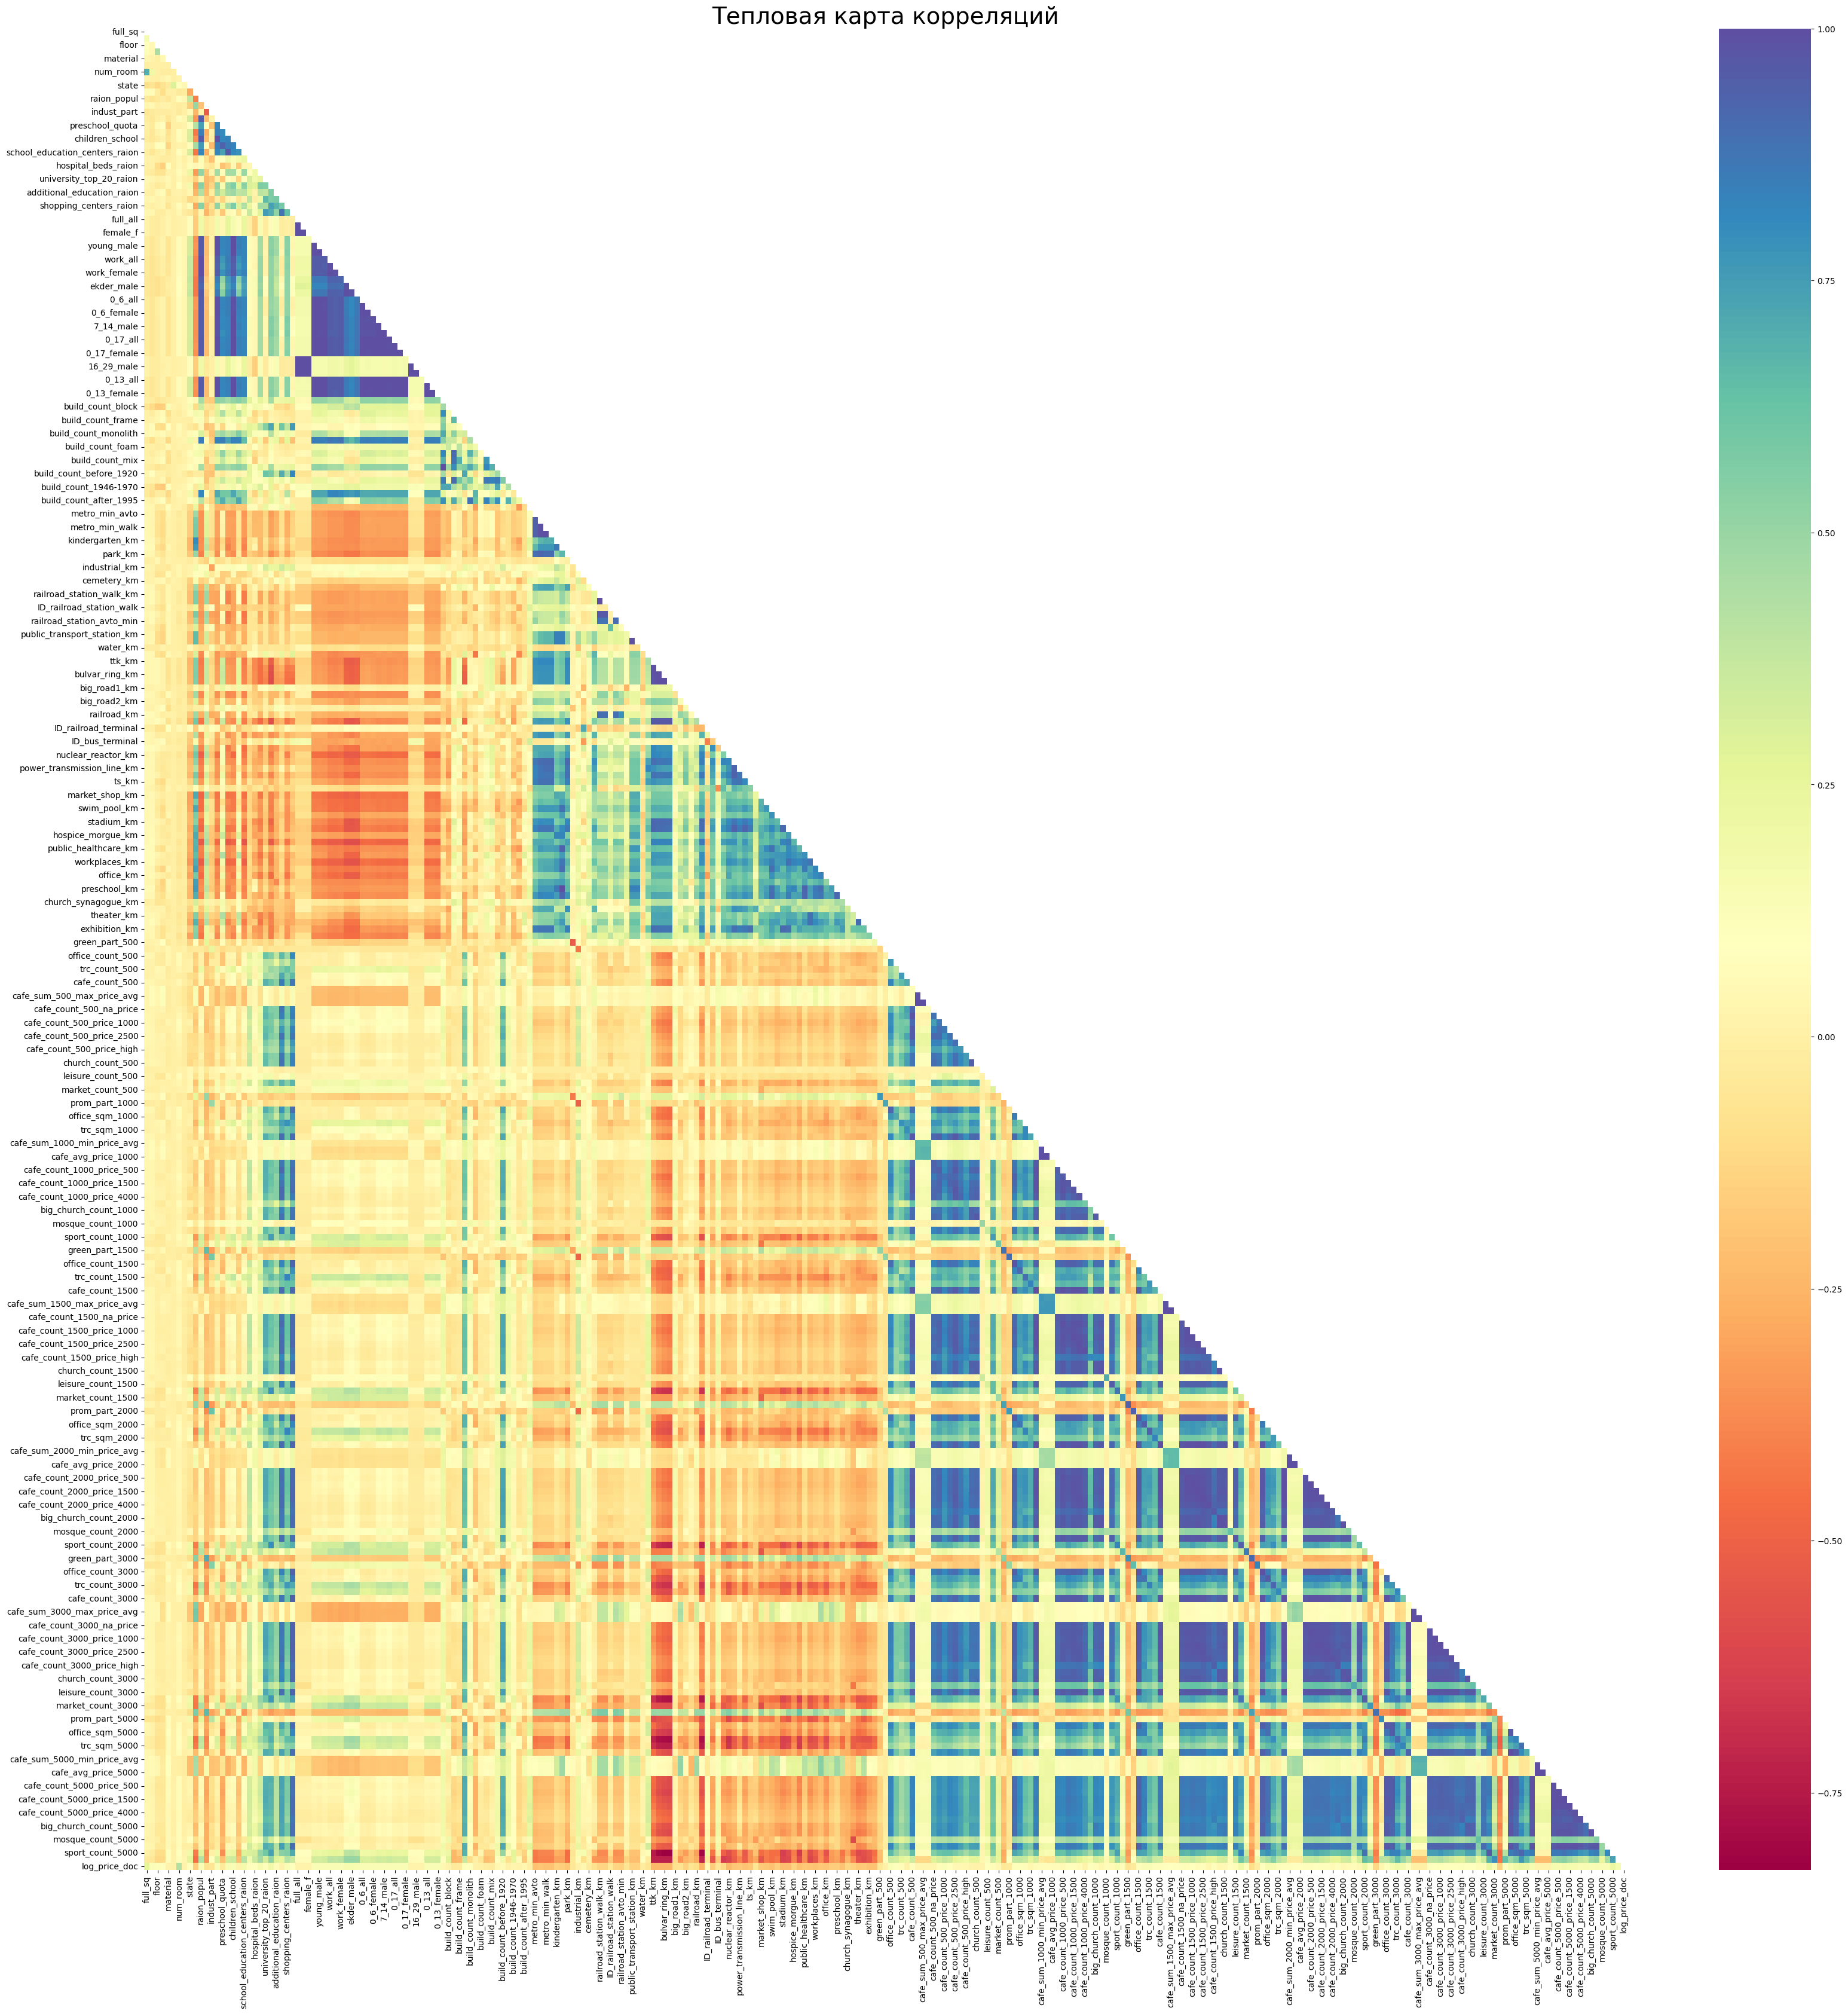

In [10]:
# нарисуем тепловую карту корреляций
corr_matrix = df[df.select_dtypes(include='number').columns].corr()
plt.figure(figsize = (40,40))
sns.heatmap(corr_matrix, mask = np.triu(np.ones_like(corr_matrix, dtype=bool)), cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title('Тепловая карта корреляций', fontsize=28)
plt.savefig('Тепловая карта корреляций.png', dpi= 600)
plt.show()

Видно, что в данных присутствует много коррелирующих признаков

Теперь построим тепловую карту пропущенных значений

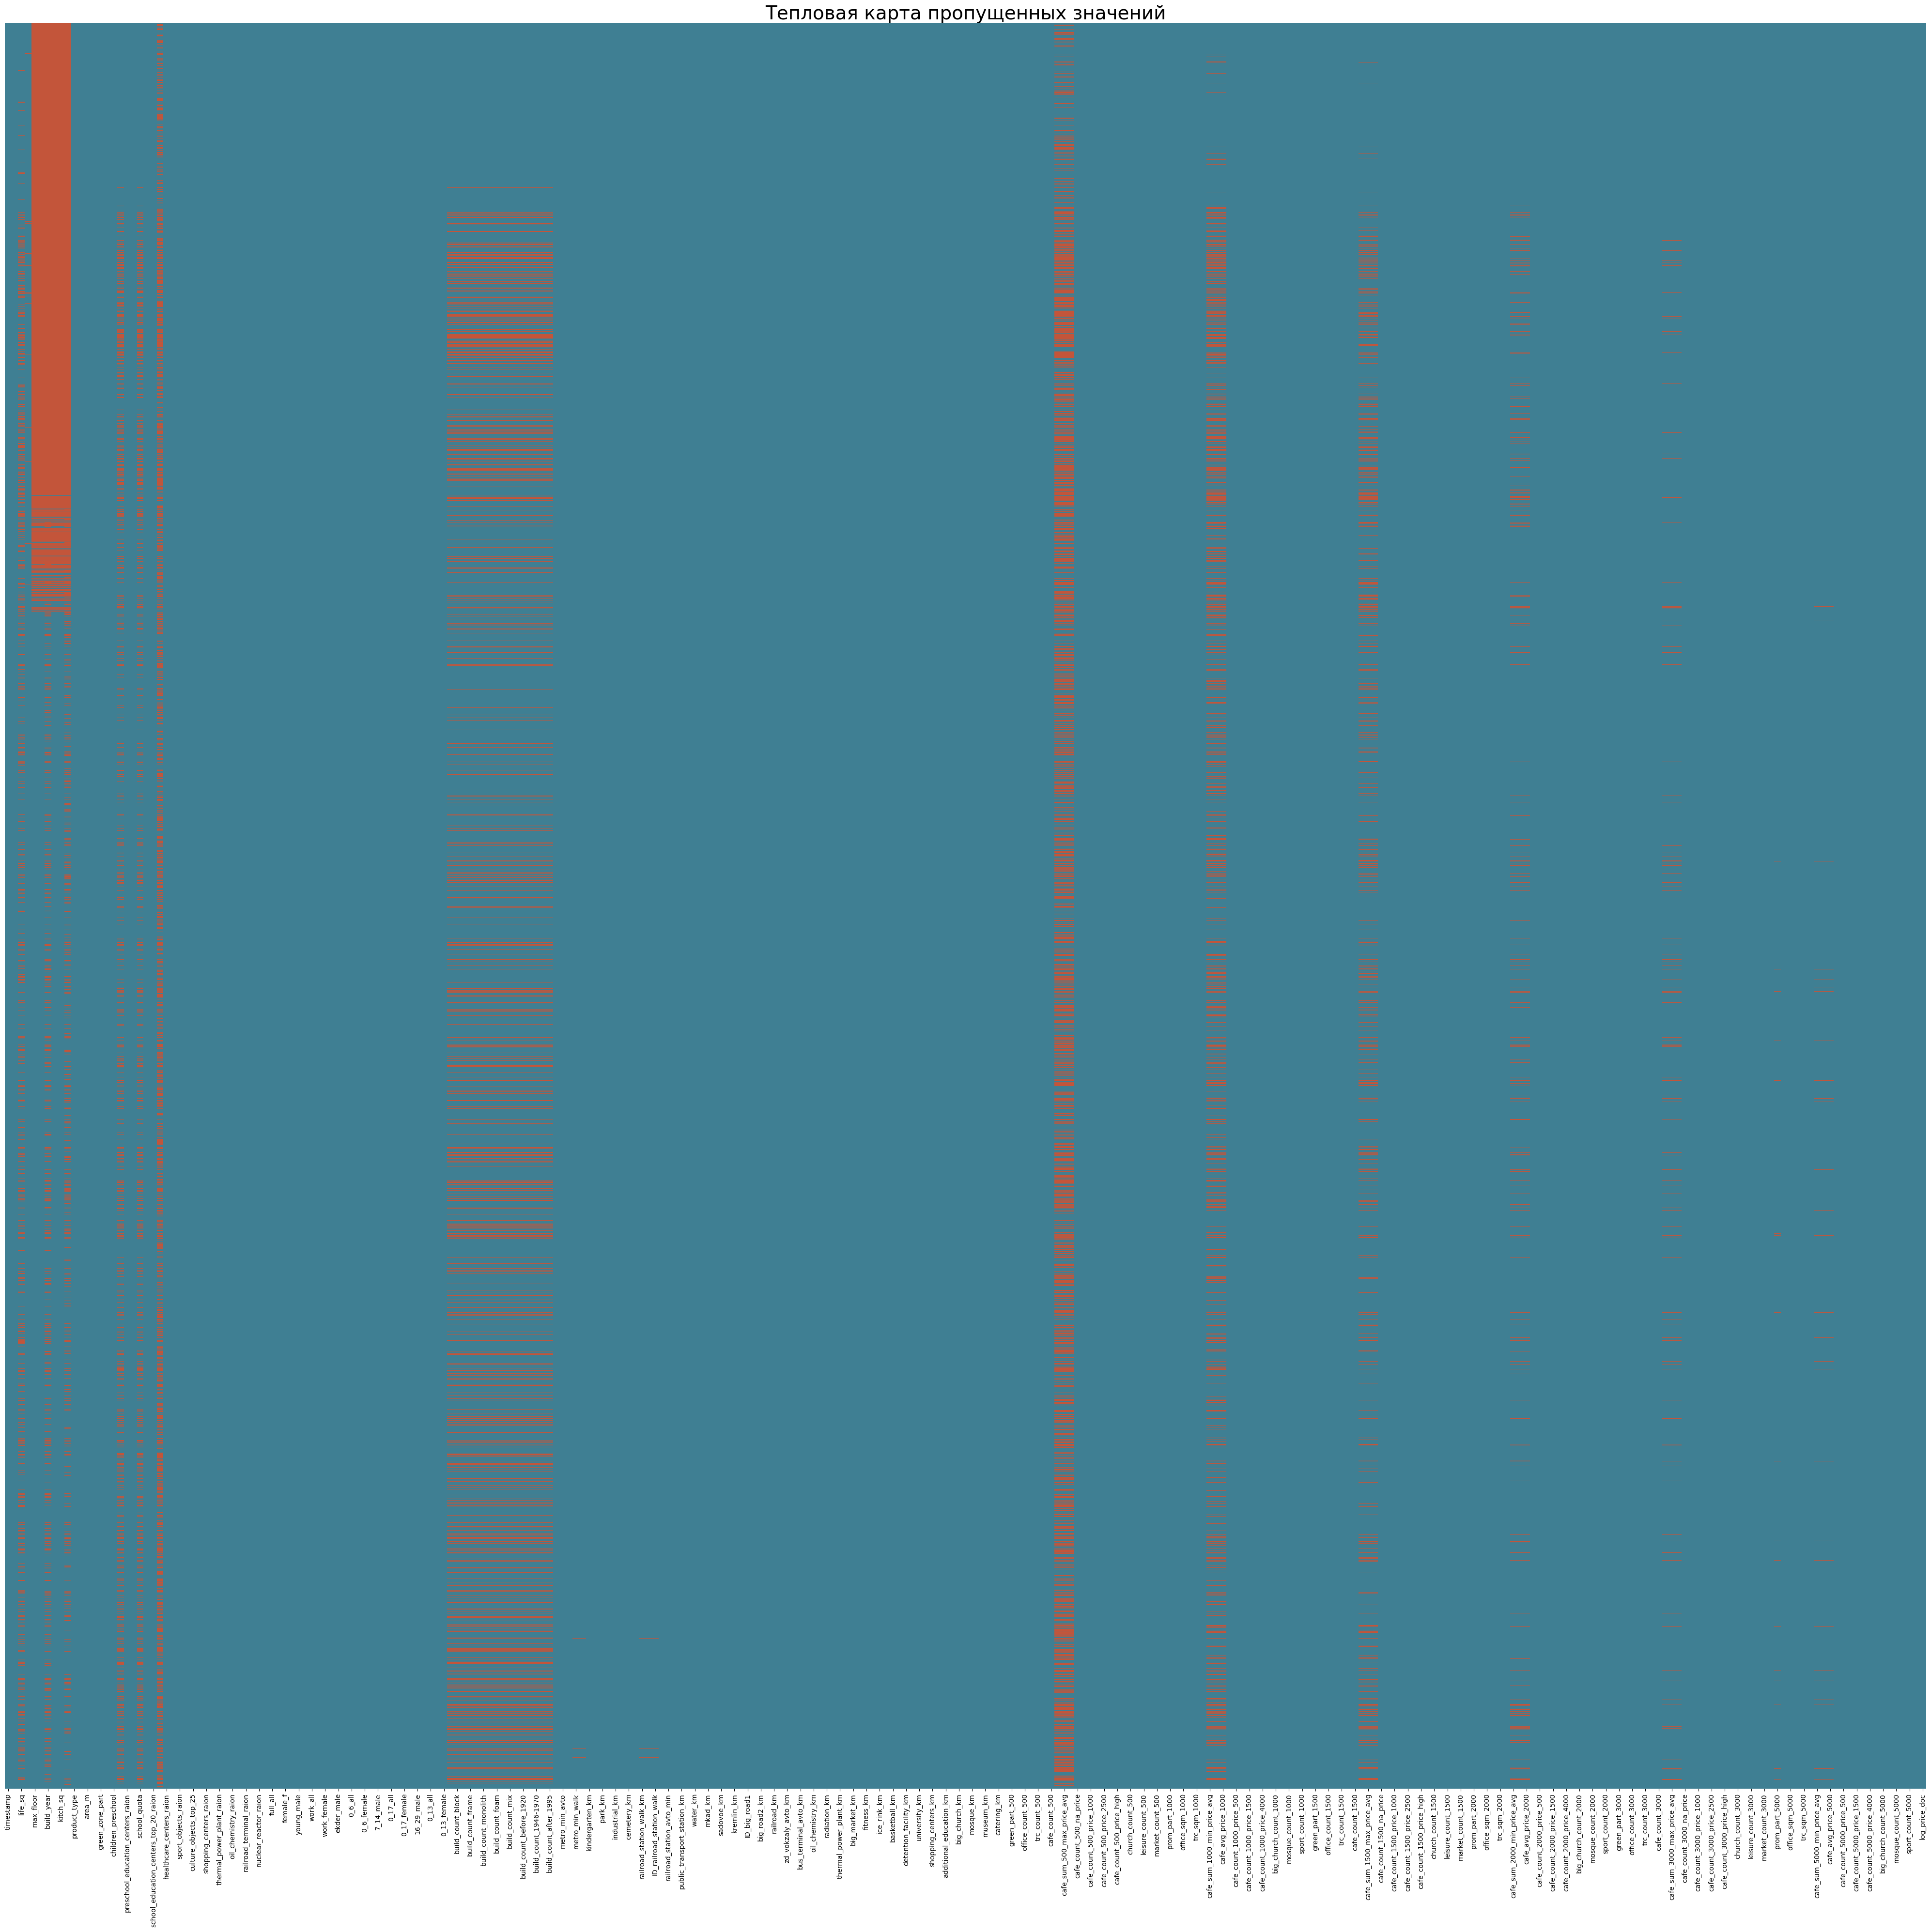

In [11]:
# Нарисуем тепловую карту пропущенных значений
plt.figure(figsize=(40, 40))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Тепловая карта пропущенных значений', fontsize=28)
plt.tight_layout()
plt.savefig('Тепловая карта пропущенных значений.png', dpi= 600)
plt.show()

Хорошо видно, что некоторые признаки содержат много пропущенных значений, в то время как другие не содержат пропусков

# Решаем пробему с пропущенными значениями

Посмотрим на типы данных в нашем датафрейме, чтлбы  выбрать потом все вещественные колонки для замены в них пропусков

In [64]:
# Посмотрим на типы данных в нашем датафрейме, чтлбы  выбрать потом все вещественные колонки для замены в них пропусков
df.dtypes.value_counts()

int64             155
float64           120
object             15
datetime64[ns]      1
Name: count, dtype: int64

Выберем все колонки с числами

In [65]:
df.select_dtypes(include='number').dtypes.value_counts()

int64      155
float64    120
Name: count, dtype: int64

In [66]:
# выберем все колонки с цифрами
numeric_columns = df.loc[:, (df.dtypes==np.int64) | (df.dtypes==np.float64)].columns

# или так
numeric_columns2 = df.select_dtypes(include='number').columns

In [15]:
(numeric_columns == numeric_columns2).any()

np.True_

In [67]:
df[numeric_columns].head(1)

full_sq  life_sq  floor  max_floor  material  build_year  num_room  \
0       43     27.0    4.0        NaN       NaN         NaN       NaN   

   kitch_sq  state     area_m  raion_popul  green_zone_part  indust_part  \
0       NaN    NaN  6407578.1       155572         0.189727      0.00007   

   children_preschool  preschool_quota  preschool_education_centers_raion  \
0                9576           5001.0                                  5   

   children_school  school_quota  school_education_centers_raion  \
0            10309       11065.0                               5   

   school_education_centers_top_20_raion  hospital_beds_raion  \
0                                      0                240.0   

   healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
0                         1                        0                    7   

   additional_education_raion  culture_objects_top_25_raion  \
0                           3                             0   

   shopping_centers_raion  office_raion  full_all  male_f  female_f  \
0                      16             1     86206   40477     45729   

   young_all  young_male  young_female  work_all  work_male  work_female  \
0      21154       11007         10147     98207      52277        45930   

   ekder_all  ekder_male  ekder_female  0_6_all  0_6_male  0_6_female  \
0      36211       10580         25631     9576      4899        4677   

   7_14_all  7_14_male  7_14_female  0_17_all  0_17_male  0_17_female  \
0     10309       5463         4846     23603      12286        11317   

   16_29_all  16_29_male  16_29_female  0_13_all  0_13_male  0_13_female  \
0      17508        9425          8083     18654       9709         8945   

   raion_build_count_with_material_info  build_count_block  build_count_wood  \
0                                 211.0               25.0               0.0   

   build_count_frame  build_count_brick  build_count_monolith  \
0                0.0                0.0                   2.0   

   build_count_panel  build_count_foam  build_count_slag  build_count_mix  \
0              184.0               0.0               0.0              0.0   

   raion_build_count_with_builddate_info  build_count_before_1920  \
0                                  211.0                      0.0   

   build_count_1921-1945  build_count_1946-1970  build_count_1971-1995  \
0                    0.0                    0.0                  206.0   

   build_count_after_1995  ID_metro  metro_min_avto  metro_km_avto  \
0                     5.0         1        2.590241        1.13126   

   metro_min_walk  metro_km_walk  kindergarten_km  school_km   park_km  \
0       13.575119        1.13126           0.1457   0.177975  2.158587   

   green_zone_km  industrial_km  water_treatment_km  cemetery_km  \
0       0.600973       1.080934            23.68346     1.804127   

   incineration_km  railroad_station_walk_km  railroad_station_walk_min  \
0         3.633334                  5.419893                  65.038716   

   ID_railroad_station_walk  railroad_station_avto_km  \
0                       1.0                  5.419893   

   railroad_station_avto_min  ID_railroad_station_avto  \
0                   6.905893                         1   

   public_transport_station_km  public_transport_station_min_walk  water_km  \
0                     0.274985                           3.299822  0.992631   

    mkad_km     ttk_km  sadovoe_km  bulvar_ring_km  kremlin_km  big_road1_km  \
0  1.422391  10.918587   13.100618       13.675657   15.156211      1.422391   

   ID_big_road1  big_road2_km  ID_big_road2  railroad_km  zd_vokzaly_avto_km  \
0             1      3.830951             5     1.305159           14.231961   

   ID_railroad_terminal  bus_terminal_avto_km  ID_bus_terminal  \
0                   101             24.292406                1   

   oil_chemistry_km  nuclear_reactor_km  radiation_km  \
0         18.152338            5.718519

Посмотрим на описательную статистику по колонкам с цифрами

In [68]:
# Описательная статистика
df[numeric_columns].describe()

full_sq       life_sq         floor     max_floor      material  \
count  30471.000000  24088.000000  30304.000000  20899.000000  20899.000000   
mean      54.214269     34.403271      7.670803     12.558974      1.827121   
std       38.031487     52.285733      5.319989      6.756550      1.481154   
min        0.000000      0.000000      0.000000      0.000000      1.000000   
25%       38.000000     20.000000      3.000000      9.000000      1.000000   
50%       49.000000     30.000000      6.500000     12.000000      1.000000   
75%       63.000000     43.000000     11.000000     17.000000      2.000000   
max     5326.000000   7478.000000     77.000000    117.000000      6.000000   

         build_year      num_room      kitch_sq         state        area_m  \
count  1.686600e+04  20899.000000  20899.000000  16912.000000  3.047100e+04   
mean   3.068057e+03      1.909804      6.399301      2.107025  1.765705e+07   
std    1.543878e+05      0.851805     28.265979      0.880148  2.064961e+07   
min    0.000000e+00      0.000000      0.000000      1.000000  2.081628e+06   
25%    1.967000e+03      1.000000      1.000000      1.000000  7.307411e+06   
50%    1.979000e+03      2.000000      6.000000      2.000000  1.050803e+07   
75%    2.005000e+03      2.000000      9.000000      3.000000  1.803644e+07   
max    2.005201e+07     19.000000   2014.000000     33.000000  2.060718e+08   

         raion_popul  green_zone_part   indust_part  children_preschool  \
count   30471.000000     30471.000000  30471.000000        30471.000000   
mean    84056.425552         0.218922      0.118871         5140.026156   
std     57871.285899         0.175090      0.118688         3816.625140   
min      2546.000000         0.001879      0.000000          175.000000   
25%     21819.000000         0.063755      0.019509         1706.000000   
50%     83502.000000         0.167526      0.072158         4857.000000   
75%    122862.000000         0.336177      0.195781         7103.000000   
max    247469.000000         0.852923      0.521867        19223.000000   

       preschool_quota  preschool_education_centers_raion  children_school  \
count     23783.000000                       30471.000000     30471.000000   
mean       3271.272464                           4.065111      5354.269699   
std        2169.759592                           2.993795      3989.640917   
min           0.000000                           0.000000       168.000000   
25%        1874.000000                           2.000000      1564.000000   
50%        2854.000000                           4.000000      5261.000000   
75%        4050.000000                           6.000000      7227.000000   
max       11926.000000                          13.000000     19083.000000   

       school_quota  school_education_centers_raion  \
count  23786.000000                    30471.000000   
mean    8324.970739                        4.705031   
std     4289.734174                        3.445105   
min     1012.000000                        0.000000   
25%     5782.000000                        2.000000   
50%     7377.000000                        5.000000   
75%     9891.000000                        7.000000   
max    24750.000000                       14.000000   

       school_education_centers_top_20_raion  hospital_beds_raion  \
count                           30471.000000         16030.000000   
mean                                0.109678          1190.738677   
std                                 0.333328          1057.015001   
min                                 0.000000             0.000000   
25%                                 0.000000           520.000000   
50%                                 0.000000           990.000000   
75%                                 0.000000          1786.000000   
max                                 2.000000          4849.000000   

       healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
count     

Посмотрим на пропуски в колонках с цифрами

In [69]:
#смотрим на кол-во пропусков
df[numeric_columns].isna().sum().sort_values(ascending=False)

hospital_beds_raion           14441
build_year                    13605
state                         13559
cafe_avg_price_500            13281
cafe_sum_500_max_price_avg    13281
                              ...  
office_sqm_5000                   0
trc_count_5000                    0
sport_count_5000                  0
market_count_5000                 0
log_price_doc                     0
Length: 275, dtype: int64

Чем можно заменить пропуски в колонках с числами? Самый простой вариант - средним значением по данной колонке

Различные варианты замены NaN:
самый медленный
```python
for col in numeric_columns:
    df[col] = df[col].fillna(df.describe()[col]['mean'])
```

заменим все пропуски на mean - более оптимизированный подход c numpy
```python
df[numeric_columns] = df[numeric_columns].apply(lambda x: np.where(np.isnan(x), np.nanmean(x), x))
```

заменим все пропуски на mean - более оптимизированный подход 
```python
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean().transform(lambda x: x))
```

In [19]:
# Выберем с помощью timeit наиболее быстрый способ замены NaN на среднее по колонке:

# Измерение времени для варианта с numpy
time1 = timeit.timeit(lambda: df[numeric_columns].apply(lambda x: np.where(np.isnan(x), np.nanmean(x), x)), number=100)

# Измерение времени для второго варианта c pandas
time2 = timeit.timeit(lambda: df[numeric_columns].fillna(df[numeric_columns].mean().transform(lambda x: x)), number=100)

print(f"Время выполнения варианта 1: {time1}")
print(f"Время выполнения варианта 2: {time2}")
print(f'Таким образом, первый вариант с Numpy работает на {np.round(100*(time2 - time1)/time2,2)} % секунд быстрее второго варианта')

Время выполнения варианта 1: 22.409932699985802
Время выполнения варианта 2: 34.86179080000147
Таким образом, первый вариант с Numpy работает на 35.72 % секунд быстрее второго варианта


Видно, что для данного датафрейма вариант с Numpy быстрее варианта, использующего инструменты pandas. Будем использовать самый быстрый вариант.

In [70]:
# заменим все пропуски на mean самым быстрым вариантом - с Numpy
df[numeric_columns] = df[numeric_columns].apply(lambda x: np.where(np.isnan(x), np.nanmean(x), x))

Убедимся, что пропусков нет:

In [71]:
# Проверим отсутсвие пропусков
df.isna().sum().sort_values(ascending=False)

log_price_doc                  0
timestamp                      0
full_sq                        0
cafe_sum_5000_min_price_avg    0
cafe_count_5000                0
                              ..
num_room                       0
build_year                     0
material                       0
max_floor                      0
floor                          0
Length: 291, dtype: int64

# Решаем проблему мультиколлинеарности

Теперь еще раз посмотрим на корреляцию наших признаков

In [72]:
# еще рах изучим датасет на мультиколлинеарность, после того как заменили NaN
corr_matrix = df[df.select_dtypes(include='number').columns].corr().abs()

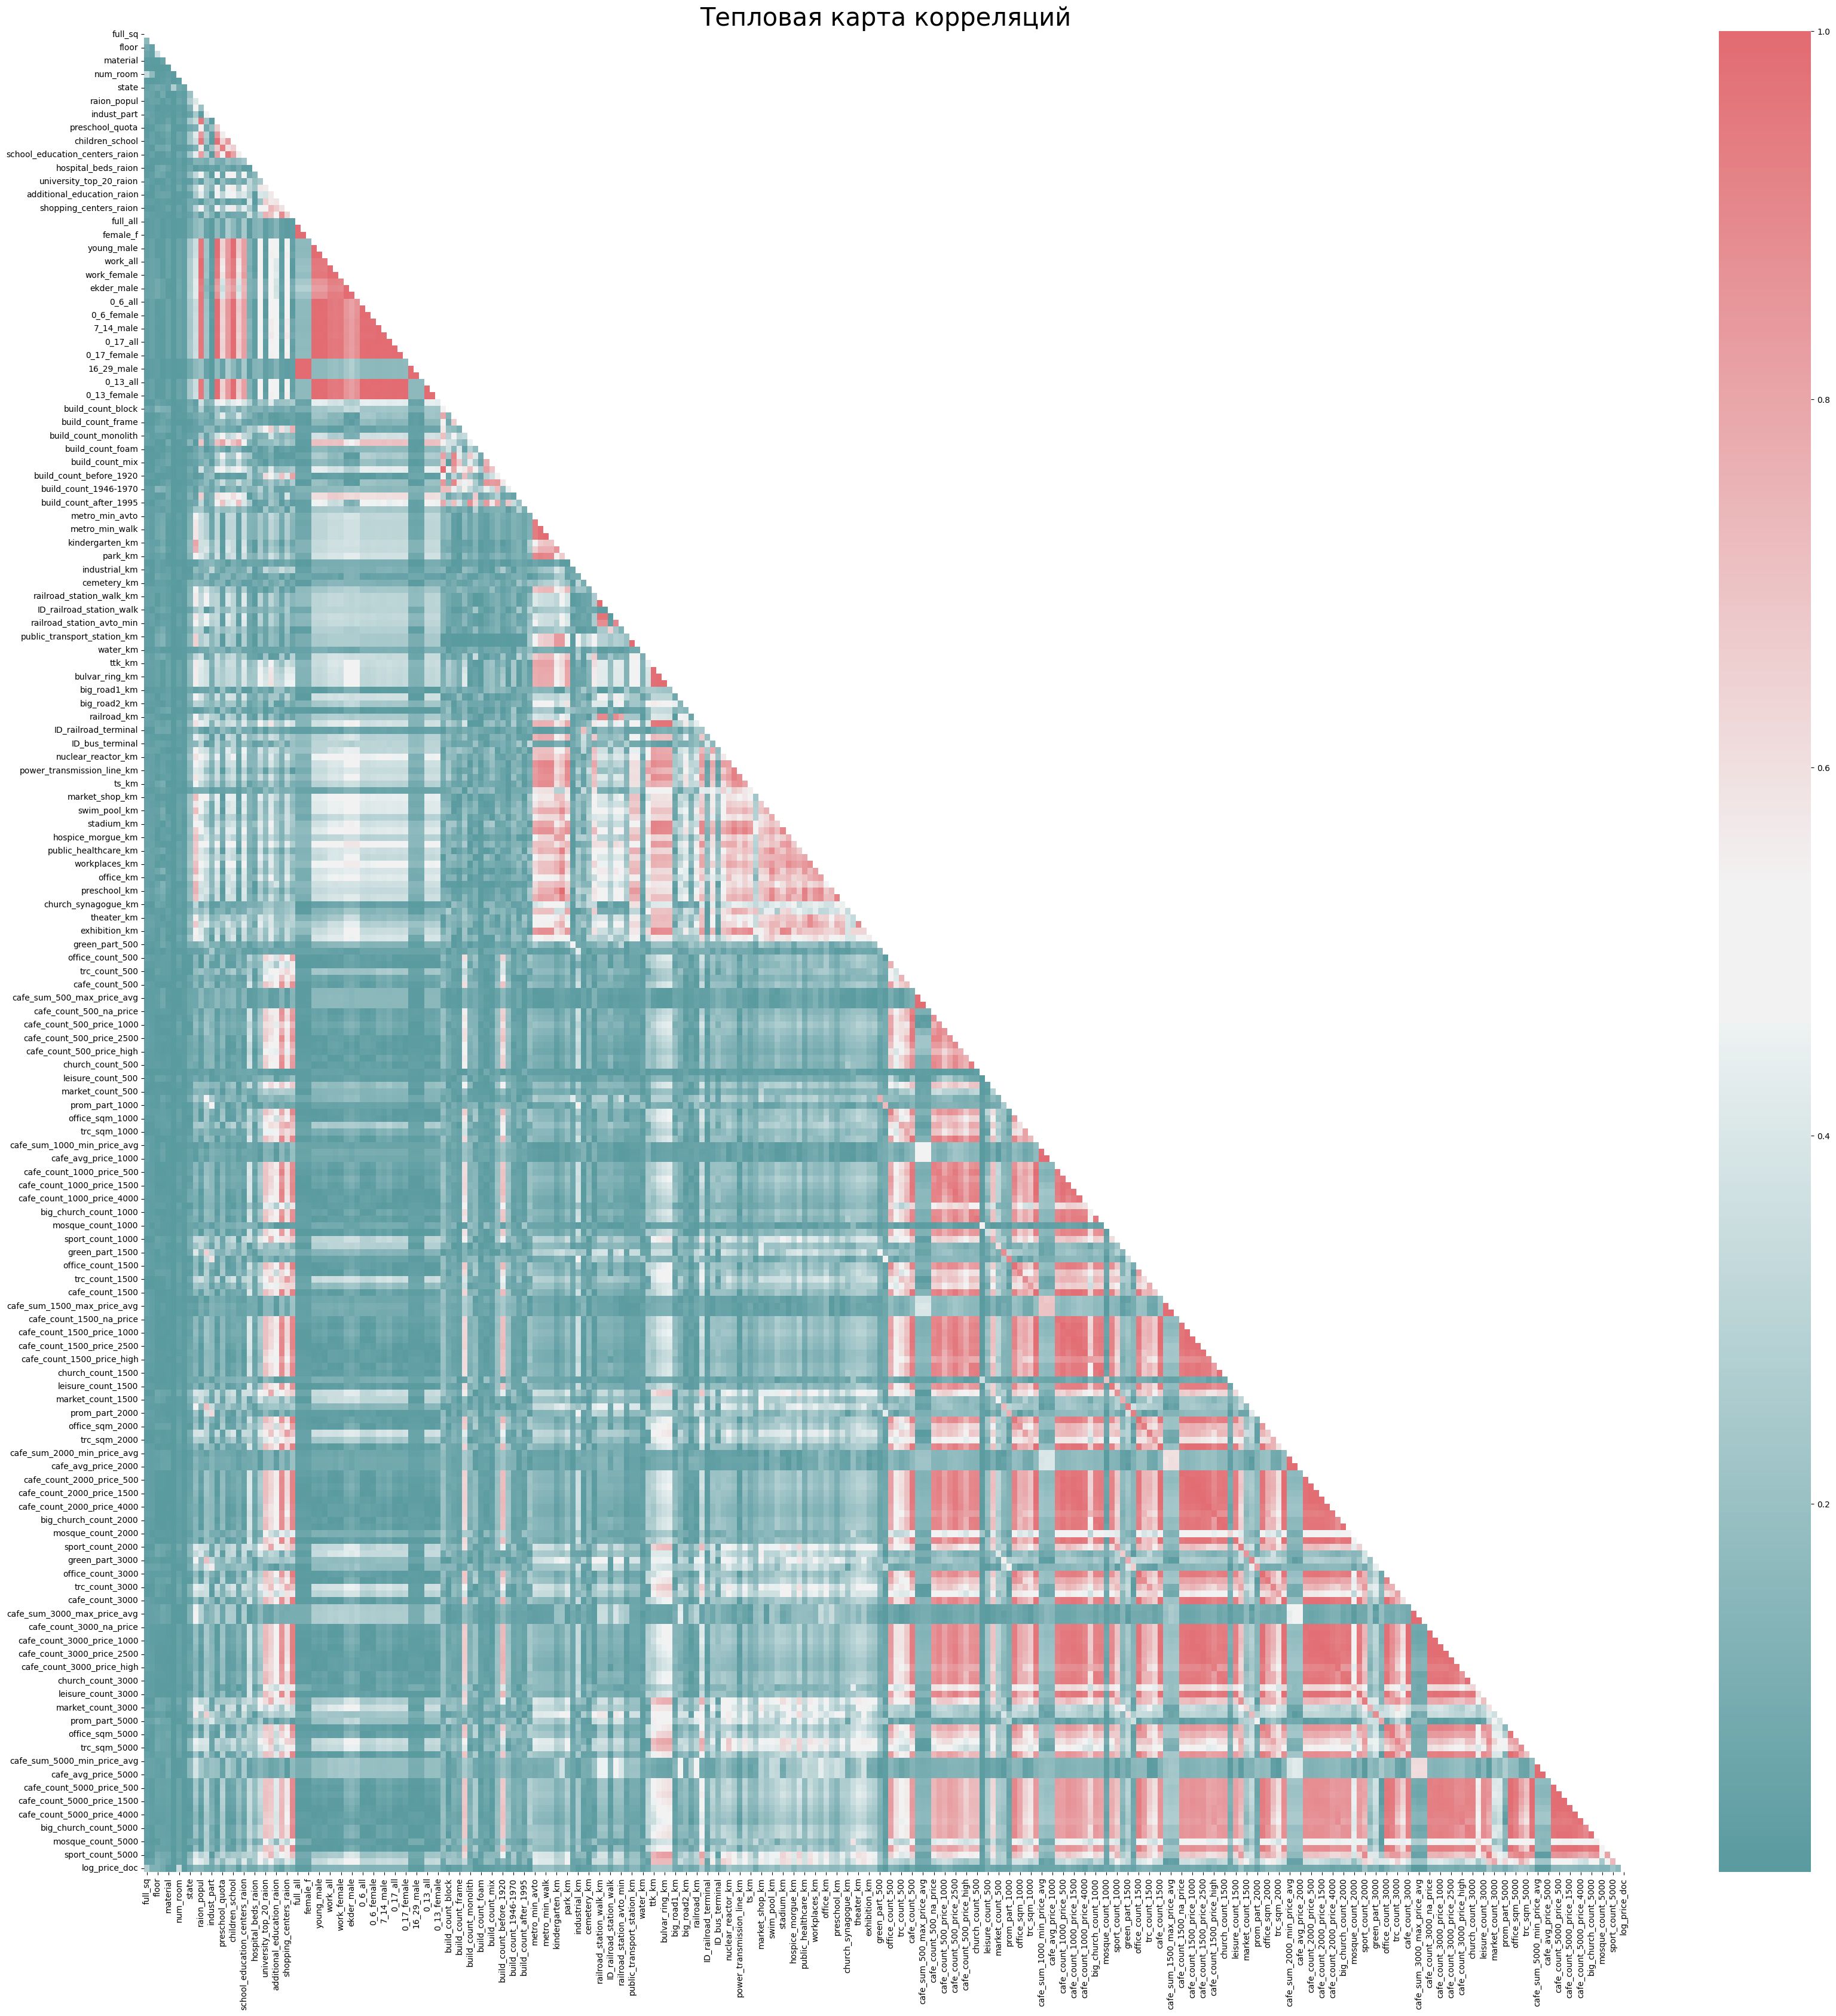

In [24]:
# нарисуем heatmap
plt.figure(figsize = (40,40))
sns.heatmap(corr_matrix, mask = np.triu(np.ones_like(corr_matrix, dtype=bool)), cmap=sns.diverging_palette(h_neg=200,h_pos=10, s=65,l=60,sep=20, n=19, as_cmap=True))
plt.title('Тепловая карта корреляций', fontsize=30)
plt.savefig('corr_abs_matrix.png', dpi = 600)
plt.show()

Посчтитаем количество признаков, у которых корреляция с другими признаками больше 0.9

In [73]:
# создадим датафрейм из верхнего треугольника корреляционной матрицы и посчтитаем кол-во признаков,
# у которых корреляция с другими признаками больше 0.9
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= threshold)]
print(f'Количество признаков, у которых корреляция больше {threshold} : {len(to_drop)}, что составляет {np.round(100*(df.shape[1] - len(to_drop))/df.shape[1], 2)} % от исходного датафрейма')

Количество признаков, у которых корреляция больше 0.9 : 147, что составляет 49.48 % от исходного датафрейма


In [27]:
# аналог:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
    

In [28]:
print(get_top_abs_correlations(df[df.select_dtypes(include='number').columns], n=6))

railroad_station_walk_km              railroad_station_walk_min                1.00000
metro_min_walk                        metro_km_walk                            1.00000
children_preschool                    0_6_all                                  1.00000
children_school                       7_14_all                                 1.00000
public_transport_station_km           public_transport_station_min_walk        1.00000
raion_build_count_with_material_info  raion_build_count_with_builddate_info    0.99999
dtype: float64


Итак, у нас очень много признаков (почти половина датасета), у которых корреляция больше 0.9. Удалим эти признаки:

In [74]:
# Удалим колонки, у которых корреляция больше 0.9
df = df.drop(to_drop, axis=1)

In [30]:
df.shape

(30471, 144)

Еще раз посмотри на топ 6 признаков с максимальной корреляцией:

In [75]:
print(get_top_abs_correlations(df[df.select_dtypes(include='number').columns], n=6))

trc_count_1000                trc_count_1500               0.897982
railroad_station_walk_km      railroad_km                  0.896954
culture_objects_top_25_raion  office_raion                 0.892094
school_km                     swim_pool_km                 0.891354
cafe_count_500                cafe_count_500_price_4000    0.889100
university_km                 theater_km                   0.888875
dtype: float64


Видно, что нет признаков с корреляцией больше 0.9!

# Квазиконстантность признаков

Посмотрим на числовые (!) признаки, у который дисперсия < 0.1. Для этого используем встроенный инструмент sklearn.feature_selection - VarianceThreshold

In [32]:
# Посмотрим на признаки, у который дисперсия < 0.1

from sklearn.feature_selection import VarianceThreshold

cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[df.select_dtypes(include='number').columns])
constant_cols = [x for x in df.select_dtypes(include='number').columns if x not in cutter.get_feature_names_out()]
df[constant_cols]

green_zone_part  indust_part  green_zone_km  cafe_count_500_price_high  \
0             0.189727     0.000070       0.600973                        0.0   
1             0.372602     0.049637       0.065321                        0.0   
2             0.112560     0.118537       0.453172                        0.0   
3             0.194703     0.069753       0.106125                        0.0   
4             0.015234     0.037316       0.236214                        0.0   
...                ...          ...            ...                        ...   
30465         0.065444     0.000078       0.189089                        1.0   
30466         0.096270     0.300323       0.139814                        0.0   
30467         0.065444     0.000078       0.271861                        0.0   
30468         0.496315     0.007122       0.427248                        0.0   
30470         0.063755     0.038693       0.559699                        0.0   

       mosque_count_500  mosque_count_1000  mosque_count_1500  \
0                   0.0                0.0                0.0   
1                   0.0                0.0                0.0   
2                   0.0                0.0                0.0   
3                   0.0                0.0                0.0   
4                   0.0                0.0                0.0   
...                 ...                ...                ...   
30465               0.0                0.0                0.0   
30466               0.0                0.0                0.0   
30467               0.0                0.0                0.0   
30468               0.0                0.0                0.0   
30470               0.0                0.0                0.0   

       mosque_count_2000  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
30465                1.0  
30466                1.0  
30467                0.0  
30468                0.0  
30470                0.0  

[30471 rows x 8 columns]

Видно, что есть 8 колонок, у которых дисперсия меньше 0.1. Но тут нужно быть аккуратным, так как много зависит от масштаба изменений признака. 
**Более предпочтительный вариант**: сначала провести масштабирование, например MinMaxScaler, а потом посмотреть на дисперсию - так мы сможем посмотреть на вариативность всех данных на едином масштабе и потом убрать те признаки, которые наиболее близки к квазиконстантным

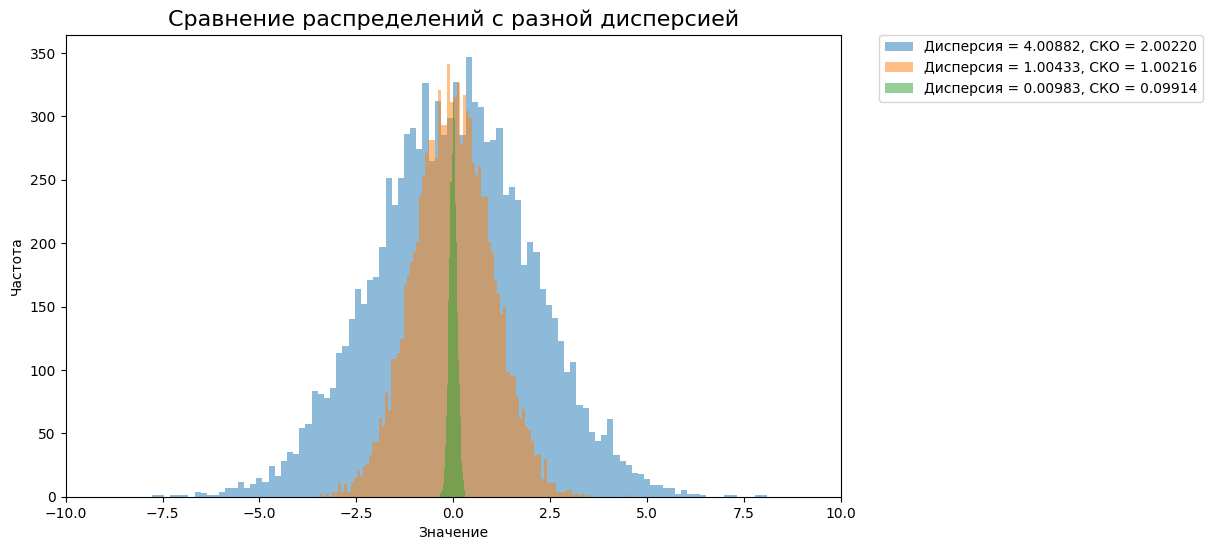

In [48]:
# Для начала - про дисперсию:
from numpy import random
rng = np.random.default_rng()
dispersion = 0.001
# Создаем два набора данных
data1 = 0.1 * rng.standard_normal(10000)  # Нормальное распределение со станд. отклонением 
data2 = rng.standard_normal(10000)  # Нормальное распределение со станд. отклонением х 2
data3 = 2 * rng.standard_normal(10000)  # Нормальное распределение со станд. отклонением х 4
# Вычисляем дисперсии
var1 = np.var(data1)
var2 = np.var(data2)
var3 = np.var(data3)
# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(data3, bins=100, alpha=0.5, label=f'Дисперсия = {var3:.5f}, СКО = {np.sqrt(var3):.5f}')
plt.hist(data2, bins=100, alpha=0.5, label=f'Дисперсия = {var2:.5f}, СКО = {np.sqrt(var2):.5f}')
plt.hist(data1, bins=100, alpha=0.5, label=f'Дисперсия = {var1:.5f}, СКО = {np.sqrt(var1):.5f}')

plt.title('Сравнение распределений с разной дисперсией', fontsize=16)
plt.xlim(-10,10)
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Посмотрим, как влияет выбор метода масштабировния на дисперсию признаков

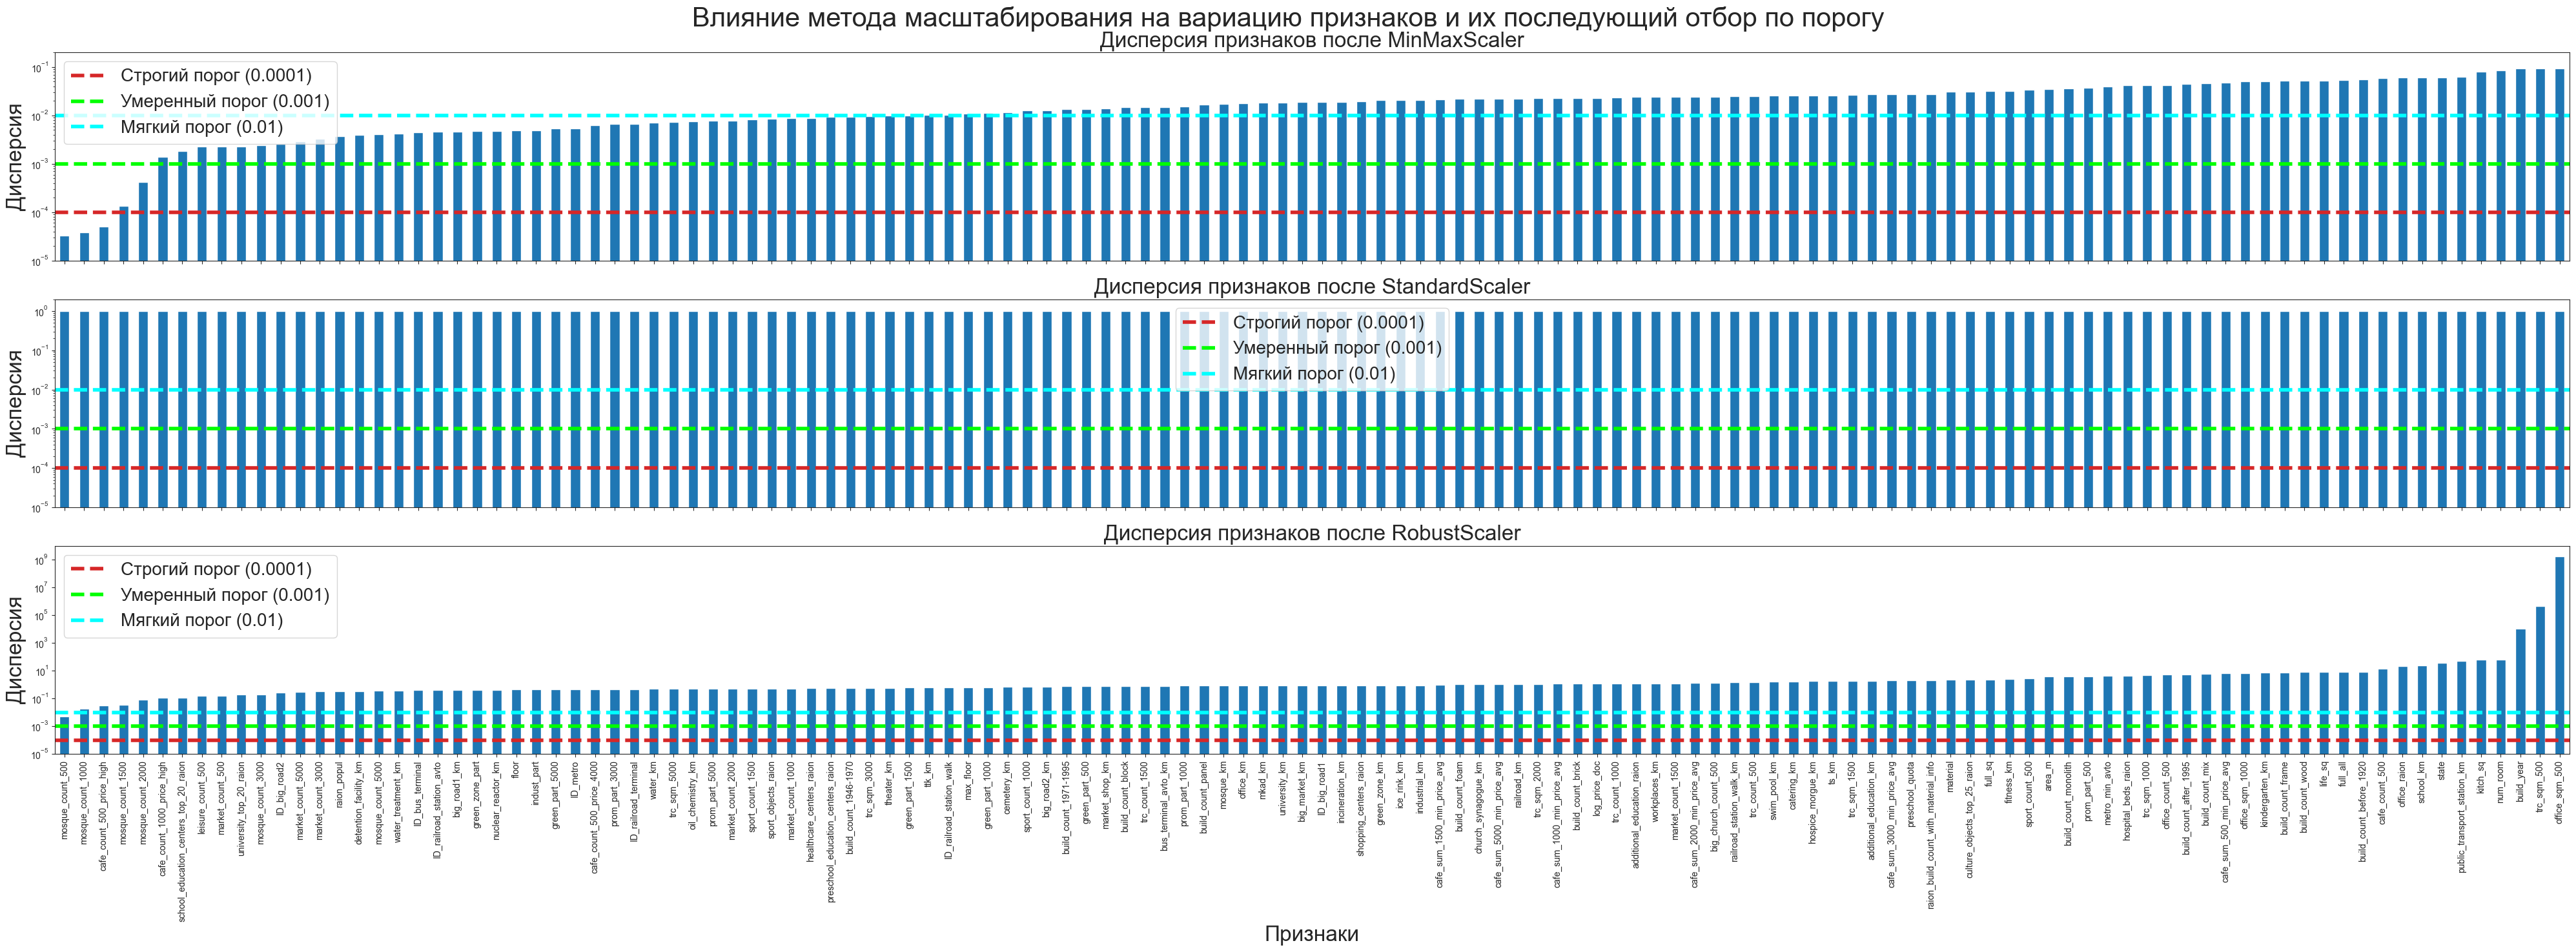

In [49]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Настройка шрифта Times New Roman
font_tnr = FontProperties(family='Times New Roman', size=10)
sns.set_style("ticks")

# Создаем подграфики без общей оси Y
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(40, 15))

ylimits = ((1e-5, 0.2), (1e-5, 2), (1e-5, 1e+10))

df_copy = df[df.select_dtypes(include='number').columns]
min_max_scaler = MinMaxScaler()
standart_scaler = StandardScaler()
robust_scaler = RobustScaler()

list_of_titles = ['Дисперсия признаков после MinMaxScaler', 'Дисперсия признаков после StandardScaler', 'Дисперсия признаков после RobustScaler']

for i, (certain_scaler, ylimit) in enumerate(zip((min_max_scaler, standart_scaler, robust_scaler), ylimits)):
    df_scaled = pd.DataFrame(certain_scaler.fit_transform(df_copy), columns=df_copy.columns)
    variances = df_scaled.var()
    sorted_variances = variances.sort_values()
    
    sorted_variances.plot(ax=axes[i], kind='bar')
    axes[i].set_title(list_of_titles[i], fontsize=24)
    axes[i].set_xlabel('Признаки', fontsize=24)
    axes[i].set_ylabel('Дисперсия', fontsize=24)
    axes[i].set_yscale('log')
    axes[i].axhline(y=0.0001, color='tab:red', linestyle='--', label='Строгий порог (0.0001)', linewidth=4)
    axes[i].axhline(y=0.001, color='lime', linestyle='--', label='Умеренный порог (0.001)', linewidth=4)
    axes[i].axhline(y=0.01, color='aqua', linestyle='--', label='Мягкий порог (0.01)', linewidth=4)
    axes[i].legend(fontsize=20)
    axes[i].set_ylim(ylimit)

plt.suptitle("Влияние метода масштабирования на вариацию признаков и их последующий отбор по порогу", fontsize=30)    
plt.tight_layout()
plt.savefig('Дисперсия признаков после MinMaxScaler, StandardScaler, RobustScaler.png', dpi = 600)
plt.show()


Разберем подробно почему получились такие результаты для каждого метода масштабирования:

**MinMaxScaler**:

Формула: `X_scaled = (X - X_min) / (X_max - X_min)`
Этот метод масштабирует все значения в диапазон `[0, 1]`
Почему дисперсия от 0 до ~0.1:
- Сохраняет относительное распределение данных
- Максимальная теоретическая дисперсия для равномерного распределения на `[0, 1]` равна 1/12 ≈ 0.0833
- Реальные данные редко имеют идеальное равномерное распределение, поэтому максимальная дисперсия чуть меньше 0.1


**StandardScaler**:

Формула: `X_scaled = (X - mean(X)) / std(X)`
Этот метод центрирует данные вокруг 0 и масштабирует к единичной дисперсии
Почему дисперсия не изменяется:
- После применения StandardScaler, дисперсия всех признаков становится равной 1
- Это происходит потому, что мы делим каждое значение на стандартное отклонение признака
- Дисперсия = (стандартное отклонение)^2, поэтому после масштабирования дисперсия всегда равна 1


**RobustScaler**:

Формула: `X_scaled = (X - median(X)) / IQR(X)`
Этот метод использует медиану и межквартильный размах вместо среднего и стандартного отклонения
Почему дисперсия от 0 до 1e+10:
- Метод не ограничивает диапазон выходных значений
- Метод устойчив к выбросам, но может сильно растянуть шкалу для признаков с маленьким IQR
- Если в данных есть экстремальные выбросы, они могут привести к очень большим значениям после масштабирования
- Квадрат этих больших значений при расчете дисперсии дает огромные числа

**Ключевые выводы**:

- *MinMaxScaler* сжимает все данные в фиксированный диапазон, ограничивая максимальную дисперсию.
- *StandardScaler* всегда приводит к единичной дисперсии для всех признаков.
- *RobustScaler* может сильно увеличить разброс данных для признаков с маленьким межквартильным размахом, особенно при наличии выбросов.

Таким образом, выбор метода масштабирования зависит от характера данных и целей анализа. *StandardScaler* обычно предпочтителен для многих алгоритмов машинного обучения, но *MinMaxScaler* или *RobustScaler* могут быть лучше в определенных ситуациях, особенно при наличии выбросов или когда важно сохранить нулевые значения.

Посмотрим на признаки, дисперсия которых, после масштабирования MinMaxScaler(!!!)  меньше threshold: < 0.001

In [50]:
# Применяем MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)

# Вычисляем дисперсию для каждого признака
variances = df_scaled.var()

# Сортируем признаки по возрастанию дисперсии
sorted_variances = variances.sort_values()

# Вывод квазиконстантных признаков (используем умеренный порог)
quasi_constant_features = sorted_variances[sorted_variances < 0.001]
print("Квазиконстантные признаки:")
print(quasi_constant_features)

Квазиконстантные признаки:
build_year    0.000033
life_sq       0.000039
full_sq       0.000051
kitch_sq      0.000135
state         0.000420
dtype: float64


Можем убрать эти колонки из датафрейма или оставить, если они нужны. В df_scaled хранится уже отмасштабированный датафрейм

Следующий подход позволяет одновременно убрать признаки и получить отмасштабированный датафрейм с помощью Pipeline:

In [449]:
# отберем признаки, дисперсия которых, после масштабирования MinMaxScaler(!!!) меньше threshold: < 0.001
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

# Создаем пайплайн с масштабированием и отбором признаков
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('variance_threshold', VarianceThreshold(threshold = 0.001))
])

# Применяем пайплайн к данным
df_selected_array = pipeline.fit_transform(df_copy)

# Получаем маску выбранных признаков
feature_mask = pipeline.named_steps['variance_threshold'].get_support()

# Выбираем названия колонок, которые прошли отбор
selected_features = df_copy.columns[feature_mask]

# Создаем новый DataFrame с отобранными признаками
X_selected_df = pd.DataFrame(df_selected_array, columns=selected_features, index=df_copy.index)

# Теперь X_selected_df - это DataFrame с отобранными признаками
print(f'Размер датафрейма после отбора признаков: {X_selected_df.shape}. Убрано {df_copy.shape[1] - X_selected_df.shape[1]} колонок, что составляет {np.round(100 * (df_copy.shape[1] - X_selected_df.shape[1])/df_copy.shape[1],2)} % от исходного датафрейма')
#print(f'Кол-во колонок, у которых дисперсия меньше {threshold}: {len(cutter.get_feature_names_out())} из {cutter.n_features_in_}. Имена колонок: {cutter.get_feature_names_out()}')

Размер датафрейма после отбора признаков: (30471, 123). Убрано 5 колонок, что составляет 3.91 % от исходного датафрейма


Как видно, результаты совпадают!

У нас всего 5 колонок с дисперсией ниже порога, это не очень много, да и информация в колонках не кажется не нужно, пожтому оставим их

# Обработка категориальных признаков

In [76]:
df.dtypes.value_counts()

float64           128
object             15
datetime64[ns]      1
Name: count, dtype: int64

In [77]:
# Перейдем к категориальным колонкам
categorial_columns = df.select_dtypes(include=['object']).columns 

Посмотрим, сколько у нас категориальных признаков:

In [78]:
print(f'В датафрейме {len(categorial_columns)} категориальных колонок: {list(categorial_columns)}')

В датафрейме 15 категориальных колонок: ['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']


In [79]:
df[categorial_columns]

product_type              sub_area culture_objects_top_25  \
0         Investment              Bibirevo                     no   
1         Investment     Nagatinskij Zaton                    yes   
2         Investment        Tekstil'shhiki                     no   
3         Investment                Mitino                     no   
4         Investment             Basmannoe                     no   
...              ...                   ...                    ...   
30465  OwnerOccupier              Tverskoe                    yes   
30466     Investment              Otradnoe                     no   
30467     Investment              Tverskoe                    yes   
30468  OwnerOccupier  Poselenie Vnukovskoe                     no   
30470     Investment           Novogireevo                     no   

      thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
0                            no                 no                  no   
1                            no                 no                  no   
2                            no                 no                  no   
3                            no                 no                  no   
4                            no                 no                  no   
...                         ...                ...                 ...   
30465                        no                 no                  no   
30466                        no                yes                  no   
30467                        no                 no                  no   
30468                        no                 no                  no   
30470                        no                 no                  no   

      radiation_raion railroad_terminal_raion big_market_raion  \
0                  no                      no               no   
1                  no                      no               no   
2                 yes                      no               no   
3                  no                      no               no   
4                 yes                     yes               no   
...               ...                     ...              ...   
30465             yes                     yes               no   
30466             yes                      no               no   
30467             yes                     yes               no   
30468              no                      no               no   
30470             yes                      no               no   

      nuclear_reactor_raion detention_facility_raion water_1line  \
0                        no                       no          no   
1                        no                       no          no   
2                        no                       no          no   
3                        no                       no          no   
4                        no                       no          no   
...                     ...                      ...         ...   
30465                    no                      yes          no   
30466                    no                       no          no   
30467                    no                      yes          no   
30468                    no                       no          no   
30470                    no                       no          no   

      big_road1_1line railroad_1line    ecology  
0                  no             no       good  
1                  no             no  excellent  
2                  no             no       poor  
3                  no             no       good  
4                  no            yes  excellent  
...               ...            ...        ...  
30465              no             no  excellent  
30466              no             no       good  
30467              no             no       poor  
30468              no             no    no data  
30470              no             no       poor  

[30471 rows x 15 columns]

Можно посмотреть на описание категориальных признаков

In [80]:
# Получим описание категориальных колонок:
descr_of_categorial_data = df.describe(include='object')

In [81]:
descr_of_categorial_data

product_type             sub_area culture_objects_top_25  \
count         30471                30471                  30471   
unique            2                  146                      2   
top      Investment  Poselenie Sosenskoe                     no   
freq          19448                 1776                  28543   

       thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
count                      30471              30471               30471   
unique                         2                  2                   2   
top                           no                 no                  no   
freq                       28817              28155               30175   

       radiation_raion railroad_terminal_raion big_market_raion  \
count            30471                   30471            30471   
unique               2                       2                2   
top                 no                      no               no   
freq             19600                   29335            27649   

       nuclear_reactor_raion detention_facility_raion water_1line  \
count                  30471                    30471       30471   
unique                     2                        2           2   
top                       no                       no          no   
freq                   29608                    27427       28134   

       big_road1_1line railroad_1line ecology  
count            30471          30471   30471  
unique               2              2       5  
top                 no             no    poor  
freq             29690          29578    8018

## Кодировка категориальных признаков: One-Hot-Encoding и Mean-Encoding

Закодируем категориальные колонки методом One-Hot-Encoding, если категорий в колонке не больше 4, или Mean-Encoding, если категорий 5 и больше

In [82]:
for cols in categorial_columns:     
    if descr_of_categorial_data.loc['unique',cols] < 5:
        df = pd.concat((df,pd.get_dummies(df[cols], dtype=int, prefix=cols, drop_first=True)), axis =1).drop(cols, axis = 1)
    else:
        df[cols] = df.groupby(cols)['log_price_doc'].transform(lambda x : np.mean(x))

Еще один вариант:
```python
for col in categorial_columns:
    if df4[col].nunique()<5:
        one_hot = pd.get_dummies(df4[col],  dtype=int, prefix=col,drop_first=True)
        df4 = pd.concat((df4.drop(col, axis=1), one_hot), axis=1)
    else:
        mean_target = df4.groupby(col)['log_price_doc'].mean()
        df4[col] = df4[col].map(mean_target)```

In [83]:
df.head()

timestamp  full_sq  life_sq  floor  max_floor  material   build_year  \
0 2011-08-20     43.0     27.0    4.0  12.558974  1.827121  3068.057097   
1 2011-08-23     34.0     19.0    3.0  12.558974  1.827121  3068.057097   
2 2011-08-27     43.0     29.0    2.0  12.558974  1.827121  3068.057097   
3 2011-09-01     89.0     50.0    9.0  12.558974  1.827121  3068.057097   
4 2011-09-05     77.0     77.0    4.0  12.558974  1.827121  3068.057097   

   num_room  kitch_sq     state   sub_area        area_m  raion_popul  \
0  1.909804  6.399301  2.107025  15.594247  6.407578e+06     155572.0   
1  1.909804  6.399301  2.107025  15.864842  9.589337e+06     115352.0   
2  1.909804  6.399301  2.107025  15.613141  4.808270e+06     101708.0   
3  1.909804  6.399301  2.107025  15.914449  1.258354e+07     178473.0   
4  1.909804  6.399301  2.107025  16.091227  8.398461e+06     108171.0   

   green_zone_part  indust_part  preschool_quota  \
0         0.189727     0.000070           5001.0   
1         0.372602     0.049637           3119.0   
2         0.112560     0.118537           1463.0   
3         0.194703     0.069753           6839.0   
4         0.015234     0.037316           3240.0   

   preschool_education_centers_raion  school_education_centers_top_20_raion  \
0                                5.0                                    0.0   
1                                5.0                                    0.0   
2                                4.0                                    0.0   
3                                9.0                                    0.0   
4                                7.0                                    0.0   

   hospital_beds_raion  healthcare_centers_raion  university_top_20_raion  \
0           240.000000                       1.0                      0.0   
1           229.000000                       1.0                      0.0   
2          1183.000000                       1.0                      0.0   
3          1190.738677                       1.0                      0.0   
4           562.000000                       4.0                      2.0   

   sport_objects_raion  additional_education_raion  \
0                  7.0                         3.0   
1                  6.0                         1.0   
2                  5.0                         1.0   
3                 17.0                         6.0   
4                 25.0                         2.0   

   culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
0                           0.0                    16.0           1.0   
1                           1.0                     3.0           0.0   
2                           0.0                     0.0           1.0   
3                           0.0                    11.0           4.0   
4                           0.0                    10.0          93.0   

   full_all  raion_build_count_with_material_info  build_count_block  \
0   86206.0                                 211.0               25.0   
1   76284.0                                 245.0               83.0   
2  101982.0                                 330.0               59.0   
3   21155.0                                 458.0                9.0   
4   28179.0                                 746.0               48.0   

   build_count_wood  build_count_frame  build_count_brick  \
0               0.0                0.0                0.0   
1               1.0                0.0               67.0   
2               0.0                0.0              206.0   
3              51.0               12.0              124.0   
4               0.0                0.0              643.0   

   build_count_monolith  build_count_panel  build_count_foam  build_count_mix  \
0                   2.0              184.0               0.0              0.0   
1                   4.0               90.0               0.0              0.0   
2                   4.0               60.0             

In [85]:
print(f'Таким образом, после кодировки категориальных колонок получили датафрейм с {df.shape[1]} колонками')

Таким образом, после кодировки категориальных колонок получили датафрейм с 144 колонками


Таким образом, после кодировки мы не увеличили размер датафрейма

У нас осталась колонка с датой timestamp - сделаем колонки с месяцами и годами, чтобы помесячно и по годам посмотреть на данные датафрейма и понять, нужна ли такая колонка нам

In [86]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

In [87]:
df.shape

(30471, 146)

Отсортируем все данные по времени, чтобы потом корректно строить модель и делить на данные на фолды по времени

In [88]:
df = df.sort_values('timestamp')

Исследуем, как таргетная переменная 'log_price_doc' изменяется по годам

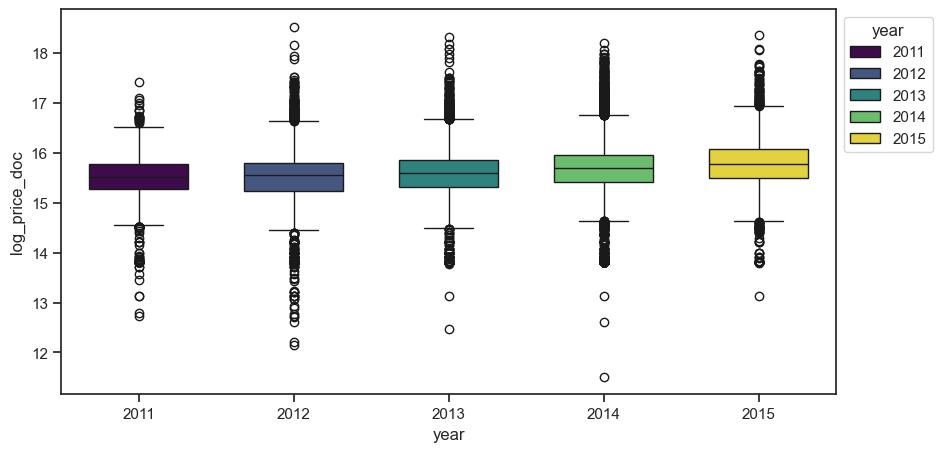

In [89]:
plt.figure(figsize = (10,5))
sns.set_theme(style="ticks", palette="pastel")
ax = sns.boxplot(y = 'log_price_doc', x = df['year'].astype('category'), data = df, hue='year', palette='viridis', gap=.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Видно, что изменения есть, пожтому колонку нужно оставить, закодируем ее One-Hot-Encoding

In [90]:
df = pd.concat((df,pd.get_dummies(df['year'], dtype=int, prefix='year', drop_first=True)), axis =1).drop('year', axis = 1)

Теперь посмотрим на изменения таргетной переменной 'log_price_doc' в разные месяцы

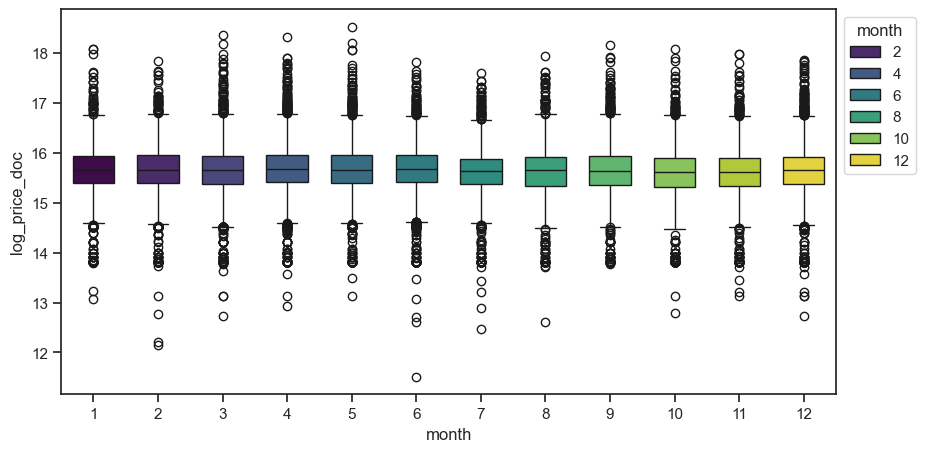

In [91]:
plt.figure(figsize = (10,5))
sns.set_theme(style="ticks", palette="pastel")
ax = sns.boxplot(y = 'log_price_doc', x = df['month'].astype('category'), data = df, hue='month', palette='viridis', gap=.2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Отчетливо видно, что есть изменения таргетной переменной в разные месяца, как медианное значение, так и выбросы. Поэтому это тоже важная колонка, оставим ее и закодируем One-Hot-Encoding

In [92]:
df = pd.concat((df,pd.get_dummies(df['month'], dtype=int, prefix='month', drop_first=True)), axis =1).drop('month', axis = 1)

Сдеалем еще есколько исследований наших данных

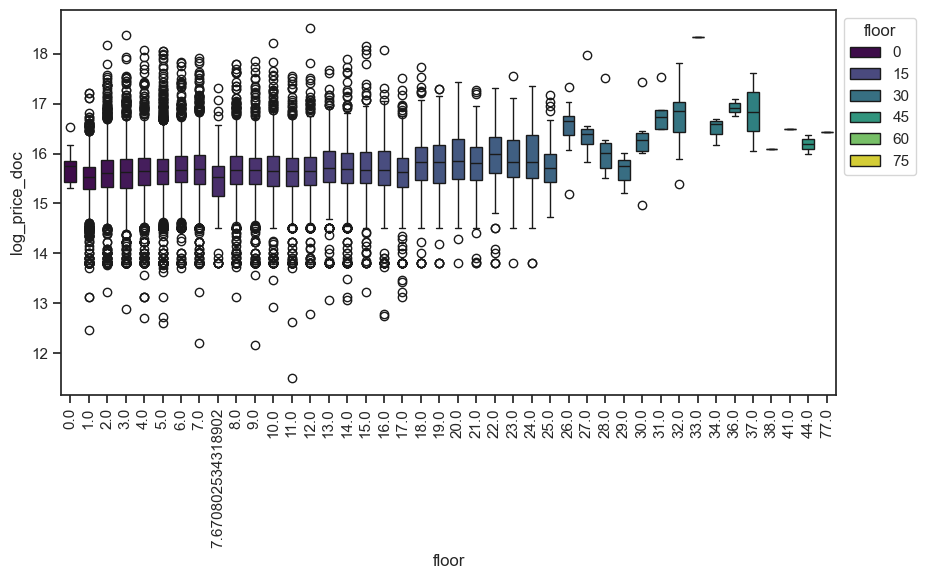

In [93]:
plt.figure(figsize = (10,5))
sns.set_theme(style="ticks", palette="pastel")
ax = sns.boxplot(y = 'log_price_doc', x = df['floor'].astype('category'), data = df, hue='floor', palette='viridis', gap=.2)
plt.setp(ax.get_xticklabels(), rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

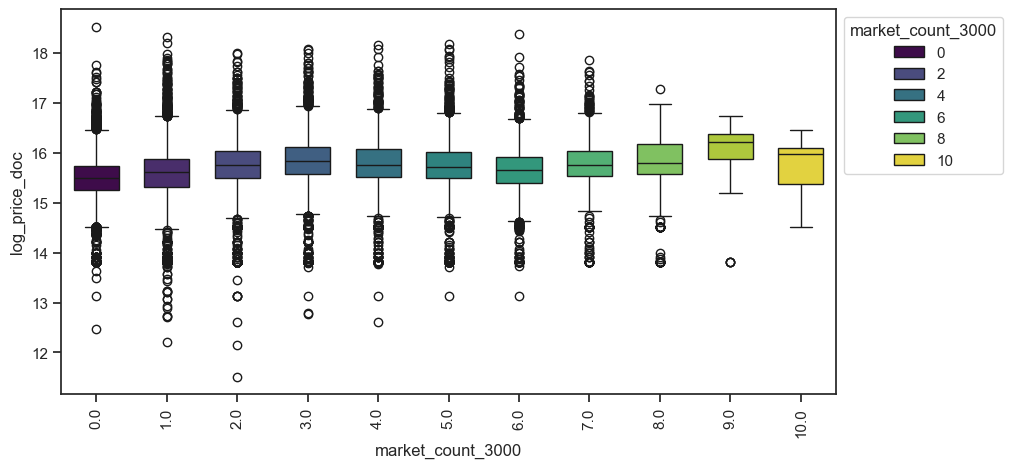

In [94]:
plt.figure(figsize = (10,5))
sns.set_theme(style="ticks", palette="pastel")
ax = sns.boxplot(y = 'log_price_doc', x = df['market_count_3000'].astype('category'), data = df, hue='market_count_3000', palette='viridis', gap=.2)
plt.setp(ax.get_xticklabels(), rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Удалим теперь дату из данных:

In [95]:
df = df.drop('timestamp', axis=1)

# Строим базовую модель

Разделим наши датафрейм на признаки (X) и таргетную переменную (Y)

In [96]:
X = df.drop('log_price_doc', axis=1)
Y = df['log_price_doc']

Для разделения наших признаков на фолды будем использовать TimeSeriesSplit. TimeSeriesSplit - это метод кросс-валидации, специально разработанный для временных рядов и данных, где нужно учитывать временную шкале или где временная шкала важна, то есть если мы хоти предсказывать какое-то событие в будущем, например цену квартиры. Он учитывает временную зависимость данных и не допускает "утечки информации из будущего".
Основные принципы:

- Данные разбиваются на последовательные блоки.
- Каждый последующий блок содержит все предыдущие данные для обучения.
- Тестовый набор всегда следует за обучающим, имитируя реальный процесс прогнозирования.
- Размер обучающего набора увеличивается с каждой итерацией.
- Тестовый набор всегда следует за обучающим.
- Каждая точка данных появляется в тестовом наборе только один раз.

Посмотрим на иллюстрацию работы по разбиению датасета признаков на фолды с помощью TimeSeriesSplit:

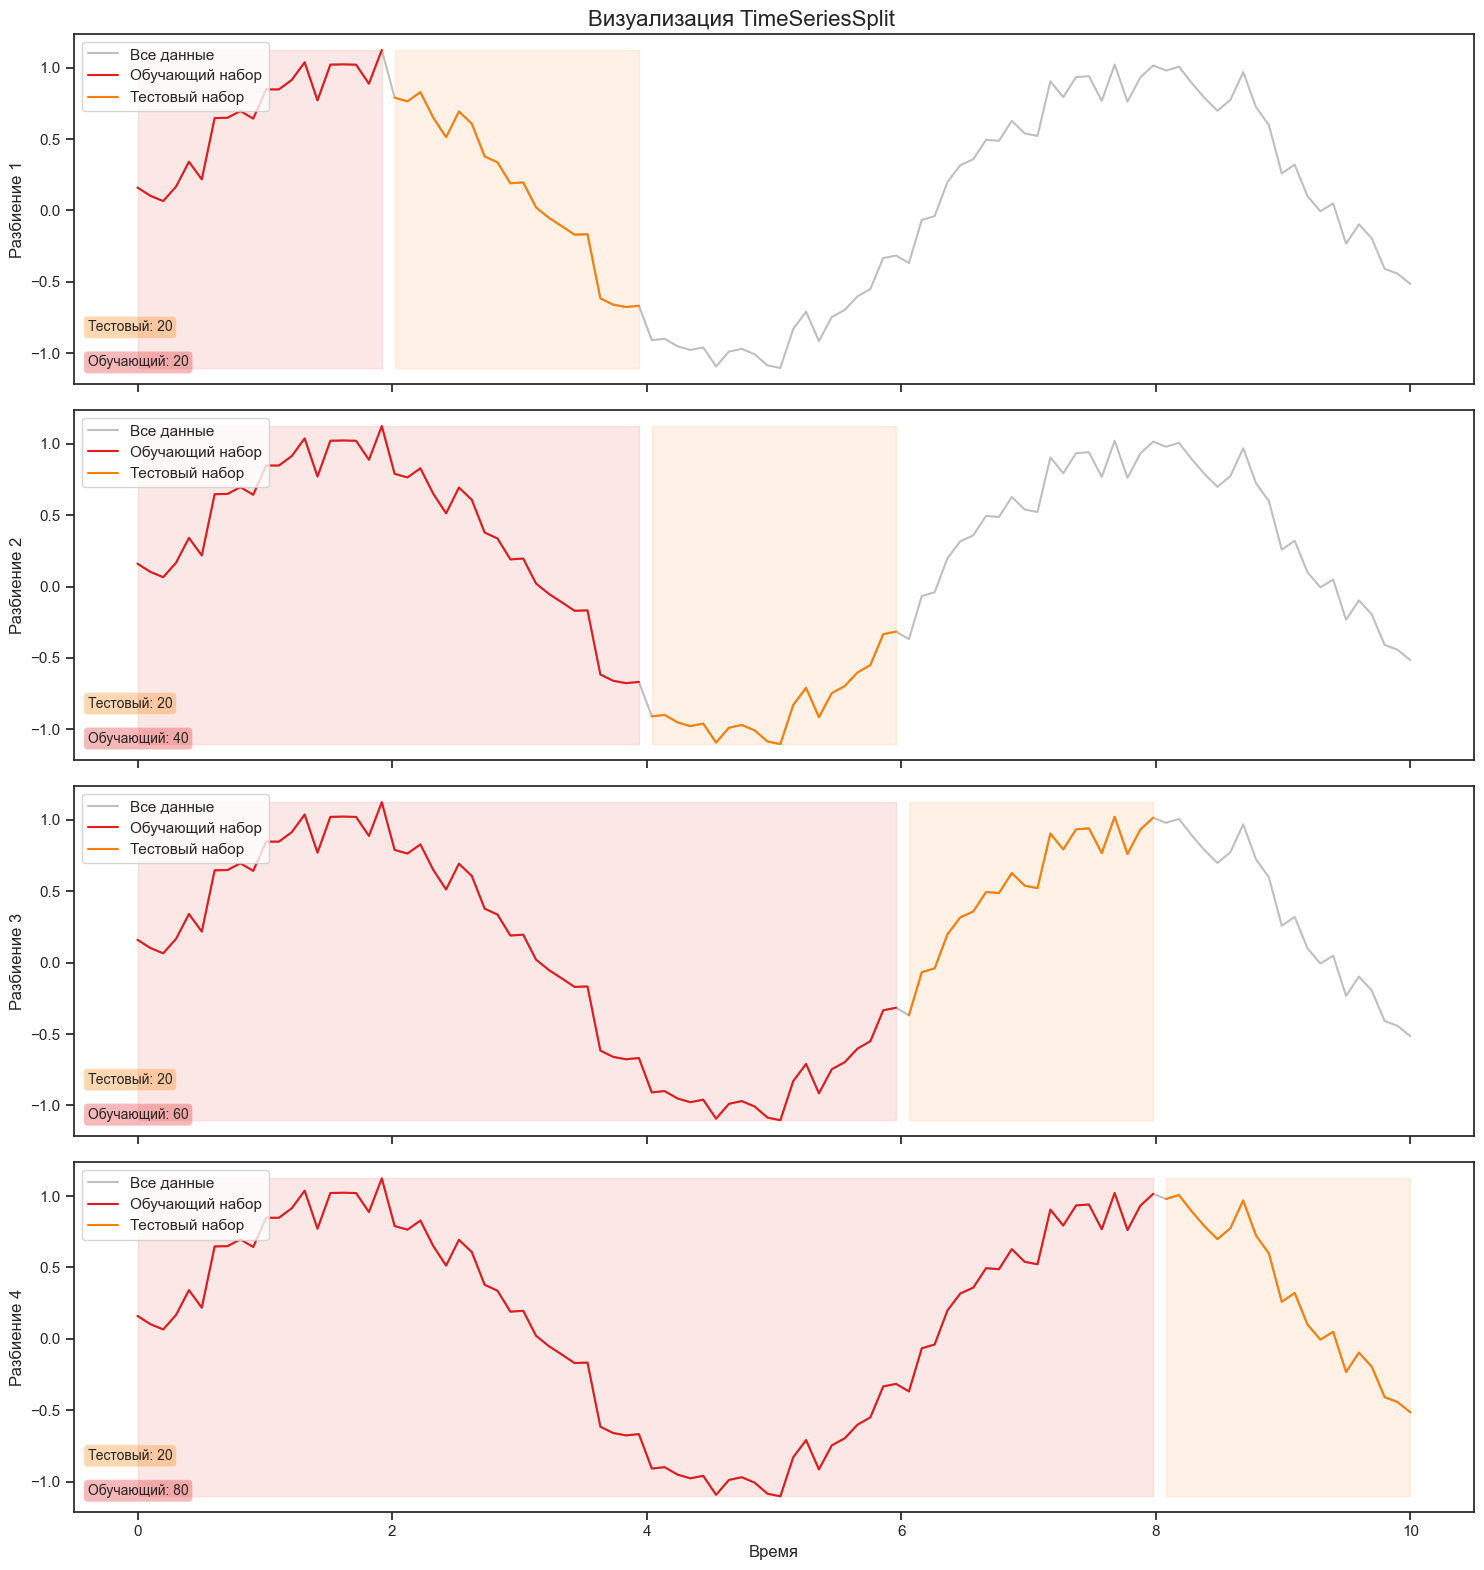

In [485]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Создаем тестовые данные
n_samples = 100
time = np.linspace(0, 10, n_samples)
values = np.sin(time) + np.random.randn(n_samples) * 0.1

# Настраиваем TimeSeriesSplit
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Настройка графика
fig, axs = plt.subplots(n_splits, 1, figsize=(15, 4*n_splits), sharex=True)


colors = plt.get_cmap('Set1')(np.linspace(0, 1, 3))

for i, (train_index, test_index) in enumerate(tscv.split(values)):
    train_data = values[train_index]
    test_data = values[test_index]
    
    axs[i].plot(time, values, color='gray', alpha=0.5, label='Все данные')
    axs[i].plot(time[train_index], train_data, color=colors[0], label='Обучающий набор')
    axs[i].plot(time[test_index], test_data, color=colors[1], label='Тестовый набор')
    
    axs[i].fill_between(time[train_index], min(values), max(values), color=colors[0], alpha=0.1)
    axs[i].fill_between(time[test_index], min(values), max(values), color=colors[1], alpha=0.1)
    
    axs[i].set_ylabel(f'Разбиение {i+1}')
    axs[i].legend(loc='upper left')
    
    # Добавляем аннотации с размерами наборов
    axs[i].annotate(f'Обучающий: {len(train_index)}', 
                    xy=(0.01, 0.05), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=0.3),
                    fontsize=10)
    axs[i].annotate(f'Тестовый: {len(test_index)}', 
                    xy=(0.01, 0.15), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", fc=colors[1], alpha=0.3),
                    fontsize=10)

axs[-1].set_xlabel('Время')
fig.suptitle("Визуализация TimeSeriesSplit", fontsize=16)
plt.tight_layout()
plt.show()

In [490]:
from sklearn.model_selection import TimeSeriesSplit

splitter = TimeSeriesSplit(n_splits=4)
# если у нас в датасете есть данные с временной шкалой и мы хотим предсказывать какое-то событие в будущем, 
# например цена квартиры в следующем году на основе параметров - то нужно использовать сплитер по времени:
# в этом случае тестовая часть датасета у нас всегда будет по времени позже, чем train

Построим модель линеной регрессии в самом простом приближении: разобьем наши признаки X на n_splits=4 фолдов, выделим тренировочную часть и тестовую и посчитаем MSLE на трейне и на тесте

In [493]:
from sklearn.linear_model import LinearRegression

train_losses_in_simpliest_straightforward_approach = []
test_losses_in_simpliest_straightforward_approach = []

for train_index, test_index in splitter.split(X):
    X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
    Y_train, Y_test = Y.to_numpy()[train_index], Y.to_numpy()[test_index]
    
    model = LinearRegression()
    model.fit(X_train,Y_train)
    
    train_losses_in_simpliest_straightforward_approach.append(np.mean(np.square(model.predict(X_train) - Y_train)))
    test_losses_in_simpliest_straightforward_approach.append(np.mean(np.square(model.predict(X_test) - Y_test)))
    
print(f'Average MSLE on train folds: {np.round(np.mean(train_losses_in_simpliest_straightforward_approach),3)}')
print(f'Average MSLE on test folds: {np.round(np.mean(test_losses_in_simpliest_straightforward_approach),3)}')


Average MSLE on train folds: 0.282
Average MSLE on test folds: 0.378


In [530]:
train_losses_simpliest_straightforward_LinearRegression = np.round(np.mean(train_losses_in_simpliest_straightforward_approach),3)
test_losses_simpliest_straightforward_LinearRegression = np.round(np.mean(test_losses_in_simpliest_straightforward_approach),3)

Видно, что ошибка на тесте сильно больше (почти на 30%) ошибки на трейне. Последне модет быть признаком сильного переобучения. Для более компактной записи процедуры кросс-валидации используем встроенные инструменты sklearn - cross_validate

In [494]:
# более компактная форма записи
from sklearn.model_selection import cross_validate


model = LinearRegression()

cross_validat_results = cross_validate(model, X,Y, scoring='neg_mean_squared_error', cv=splitter, return_train_score=True)

print(cross_validat_results)
print(f'Average MSLE on train folds using cross_validate: {-np.round(np.mean(cross_validat_results["train_score"]),3)}') 
print(f'Average MSLE on test folds using cross_validate: {-np.round(np.mean(cross_validat_results["test_score"]),3)}') 

{'fit_time': array([6.6379447 , 8.36796236, 4.37681985, 0.4437139 ]), 'score_time': array([0.02115107, 0.03125358, 0.01084805, 0.01562476]), 'test_score': array([-0.24135637, -0.73876314, -0.23376829, -0.29661369]), 'train_score': array([-0.32787629, -0.27214599, -0.2682128 , -0.2579715 ])}
Average MSLE on train folds using cross_validate: 0.282
Average MSLE on test folds using cross_validate: 0.378


Хорошо видно, что результаты сопадают, значит встроенные инструменты работают верно

In [241]:
# Видим, что результаты совпадают, в будущем будем пользоваться cross_validate

## Применим регуляризацию

Какие есть методы борьбы с переобучением? Первое - это регуляризация: Lasso или Ridge. Посчитаем ошибки на кроссвалидации после регуляризаций Lasso и Ridge и сравним их

In [500]:
from sklearn.linear_model import Lasso, Ridge

splitter = TimeSeriesSplit(n_splits=4)
model_lasso = Lasso(max_iter = 100000)

cross_validate_lasso = cross_validate(model_lasso, X, Y, scoring='neg_mean_squared_error', cv=splitter, return_train_score=True)
train_losses_after_Lasso = -np.round(np.mean(cross_validate_lasso["train_score"]),3)
test_losses_after_Lasso = -np.round(np.mean(cross_validate_lasso["test_score"]),3)
print(f'Average MSLE on train folds using Lasso regularisation and cross validation: {-np.round(np.mean(cross_validate_lasso["train_score"]),3)}') 
print(f'Average MSLE on test folds using Lasso regularisation and cross validation:: {-np.round(np.mean(cross_validate_lasso["test_score"]),3)}')

model_ridge = Ridge(solver='svd', max_iter = 100000)

cross_validate_ridge = cross_validate(model_ridge, X, Y, scoring='neg_mean_squared_error', cv=splitter, return_train_score=True)
train_losses_after_Ridge = -np.round(np.mean(cross_validate_ridge["train_score"]),3)
test_losses_after_Ridge = -np.round(np.mean(cross_validate_ridge["test_score"]),3)
print(f'Average MSLE on train folds using Ridge regularisation and cross validation: {-np.round(np.mean(cross_validate_ridge["train_score"]),3)}') 
print(f'Average MSLE on test folds using Ridge regularisation and cross validation:: {-np.round(np.mean(cross_validate_ridge["test_score"]),3)}')


Average MSLE on train folds using Lasso regularisation and cross validation: 0.33
Average MSLE on test folds using Lasso regularisation and cross validation:: 0.362
Average MSLE on train folds using Ridge regularisation and cross validation: 0.282
Average MSLE on test folds using Ridge regularisation and cross validation:: 0.377


Видим, что с переобучением мы поборолись, особенно при использовнии Lasso регуляризации

Теперь проведем процедуру масштабирования - масштабирование делаем только на трейне, чтобы модель не видела будущее - тестовую выборку. Для компактной записи последовательности действий - сначала масштабирование, потом регуляризация и построение модели, используем конструктор Pipeline

In [503]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

splitter = TimeSeriesSplit(n_splits=4)
pipeline_of_ML = Pipeline(
    [
        ('scaler', MinMaxScaler()),
        ('Lasso', Lasso(max_iter=100000))
    ]
)

pipeline_of_ML.fit(X,Y)

print(pipeline_of_ML.predict(X.head(1)))

cross_validate_pipeline = cross_validate(pipeline_of_ML, X, Y, scoring='neg_mean_squared_error', cv=splitter, return_train_score=True)
train_losses_MinMaxScaler_Lasso = -np.round(np.mean(cross_validate_pipeline["train_score"]),3)
test_losses_MinMaxScaler_Lasso = -np.round(np.mean(cross_validate_pipeline["test_score"]),3)
print(f'Average MSLE on train folds using MinMaxScaler, Lasso regularisation and cross validation: {train_losses_MinMaxScaler_Lasso}') 
print(f'Average MSLE on test folds using MinMaxScaler, Lasso regularisation and cross validation:: {test_losses_MinMaxScaler_Lasso}')

splitter = TimeSeriesSplit(n_splits=4)
pipeline_of_ML = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('Lasso', Lasso(max_iter=100000))
    ]
)

splitter = TimeSeriesSplit(n_splits=4)
pipeline_of_ML.fit(X,Y)

print(pipeline_of_ML.predict(X.head(1)))

cross_validate_pipeline = cross_validate(pipeline_of_ML, X, Y, scoring='neg_mean_squared_error', cv=splitter, return_train_score=True)
train_losses_StandardScaler_Lasso = -np.round(np.mean(cross_validate_pipeline["train_score"]),3)
test_losses_StandardScaler_Lasso = -np.round(np.mean(cross_validate_pipeline["test_score"]),3)
print(f'Average MSLE on train folds using StandardScaler, Lasso regularisation and cross validation: {train_losses_StandardScaler_Lasso}') 
print(f'Average MSLE on test folds using StandardScaler, Lasso regularisation and cross validation:: {test_losses_StandardScaler_Lasso}')

splitter = TimeSeriesSplit(n_splits=4)
pipeline_of_ML = Pipeline(
    [
        ('scaler', RobustScaler()),
        ('Lasso', Lasso(max_iter=100000))
    ]
)

pipeline_of_ML.fit(X,Y)

print(pipeline_of_ML.predict(X.head(1)))

cross_validate_pipeline = cross_validate(pipeline_of_ML, X, Y, scoring='neg_mean_squared_error', cv=splitter, return_train_score=True)
train_losses_RobustScaler_Lasso = -np.round(np.mean(cross_validate_pipeline["train_score"]),3)
test_losses_RobustScaler_Lasso = -np.round(np.mean(cross_validate_pipeline["test_score"]),3)
print(f'Average MSLE on train folds using RobustScaler, Lasso regularisation and cross validation: {train_losses_RobustScaler_Lasso}') 
print(f'Average MSLE on test folds using RobustScaler, Lasso regularisation and cross validation:: {test_losses_RobustScaler_Lasso}')



[15.60948317]
Average MSLE on train folds using MinMaxScaler, Lasso regularisation and cross validation: 0.382
Average MSLE on test folds using MinMaxScaler, Lasso regularisation and cross validation:: 0.355
[15.60948317]
Average MSLE on train folds using StandardScaler, Lasso regularisation and cross validation: 0.382
Average MSLE on test folds using StandardScaler, Lasso regularisation and cross validation:: 0.355
[15.59280761]
Average MSLE on train folds using RobustScaler, Lasso regularisation and cross validation: 0.374
Average MSLE on test folds using RobustScaler, Lasso regularisation and cross validation:: 0.341


Видим, что лучший результат дало масштабирование с помощью RobustScaler и Lasso регуляризации

## Оптимизируем модель

Проведем оптимизацию модели по гиперпараметру alpha, использую инструмент GridSearchCV

In [517]:
# задаем диапазон изменений параметра alpha
alphas = np.linspace(0.0001, 5, 30)
alphas

array([1.00000000e-04, 1.72510345e-01, 3.44920690e-01, 5.17331034e-01,
       6.89741379e-01, 8.62151724e-01, 1.03456207e+00, 1.20697241e+00,
       1.37938276e+00, 1.55179310e+00, 1.72420345e+00, 1.89661379e+00,
       2.06902414e+00, 2.24143448e+00, 2.41384483e+00, 2.58625517e+00,
       2.75866552e+00, 2.93107586e+00, 3.10348621e+00, 3.27589655e+00,
       3.44830690e+00, 3.62071724e+00, 3.79312759e+00, 3.96553793e+00,
       4.13794828e+00, 4.31035862e+00, 4.48276897e+00, 4.65517931e+00,
       4.82758966e+00, 5.00000000e+00])

In [507]:
from sklearn.model_selection import GridSearchCV

splitter = TimeSeriesSplit(n_splits=4)

param_grid = {"Lasso__alpha": alphas}

pipeline_of_ML = Pipeline(
    [
        ('scaler', RobustScaler()),
        ('Lasso', Lasso(max_iter=100000))
    ]
)

search = GridSearchCV(pipeline_of_ML, param_grid, cv=splitter, scoring='neg_mean_squared_error')

search.fit(X,Y)

print(f'Best params {search.best_score_:.5f}')
print(search.best_params_)

Best params -0.30342
{'Lasso__alpha': np.float64(0.17337931034482756)}


Видим, что нашли более оптимальный параметра alpha, при котором ошибка еще уменьшилась

In [508]:
# убедимся, что все ок - передадим найденный оптимальный параметр alpha в наш пайплайн построения модели 
pipeline_of_ML.set_params(Lasso__alpha=search.best_params_['Lasso__alpha'])

Pipeline(steps=[('scaler', RobustScaler()),
                ('Lasso',
                 Lasso(alpha=np.float64(0.17337931034482756),
                       max_iter=100000))])

In [510]:
cross_validate_pipeline = cross_validate(pipeline_of_ML, X, Y, scoring='neg_mean_squared_error', cv=splitter, return_train_score=True)

train_losses_RobustScaler_Lasso_opt_alpha = -np.round(np.mean(cross_validate_pipeline["train_score"]),3)
test_losses_RobustScaler_Lasso_opt_alpha = -np.round(np.mean(cross_validate_pipeline["test_score"]),3)

print(f'Average MSLE on train folds using RobustScaler, Lasso regularisation with optimal alpha and cross validation: {train_losses_RobustScaler_Lasso_opt_alpha}') 
print(f'Average MSLE on test folds using RobustScaler, Lasso regularisation with optimal alpha and cross validation:: {test_losses_RobustScaler_Lasso_opt_alpha}')

Average MSLE on train folds using RobustScaler, Lasso regularisation with optimal alpha and cross validation: 0.351
Average MSLE on test folds using RobustScaler, Lasso regularisation with optimal alpha and cross validation:: 0.303


Видим, что результаты совпадают и мы еще больше улучшили качество модели

# Удаление выбросов

Как еще можно улучшить качество модели? Если нам важно сосредоточиться на наиболее типичный вариантах квартир, то можно удалить выбросы - нужно понимать, что в будущем на выбросах мы будем сильнее ошибаться, но так как таких вариантов мало, то в среднем наше качество модели должно улучшиться

In [511]:
# попробуем удалить выбросы таргетной переменной (см. боксплоты по годам)
data = pd.concat((X,Y), axis=1)

Отберем данные с тoп 2.5% значение таргета и тoп 97.5% значение таргета

In [512]:
top_quartile = data['log_price_doc'].quantile(0.975)
bottom_quartile = data['log_price_doc'].quantile(0.025)

print(f'Toп 2.5% значение таргета {np.round(top_quartile,2)}')
print(f'Toп 97.5% значение таргета {np.round(bottom_quartile,2)}')

Toп 2.5% значение таргета 16.7
Toп 97.5% значение таргета 13.82


Удалим из нашего датасета записи с таргетной переменной, значение которой выходят за рамки найденный крайних значений

In [513]:
data = data[(data['log_price_doc'] > bottom_quartile) & (data['log_price_doc'] < top_quartile)]

In [516]:
print(f'Удалили {df3.shape[0] - data.shape[0]} записей, что составлет {np.round(100*(df3.shape[0] - data.shape[0])/df3.shape[0],2)} % от записей в исходном датафрейме')

Удалили 1742 записей, что составлет 5.72 % от записей в исходном датафрейме


In [514]:
X_new, Y_new = data.drop('log_price_doc', axis=1), data['log_price_doc']

Проверим на новых данных качество модели, снова найдя наиболее оптимальный alpha

In [519]:
# Проверим на новых данных качество модели, снова найдя наиболее оптимальный alpha
new_splitter = TimeSeriesSplit(n_splits=4)

alphas = np.linspace(0.0001, 5, 30)

param_grid = {"Lasso__alpha": alphas}

pipeline_of_ML = Pipeline(
    [
        ('scaler', RobustScaler()),
        ('Lasso', Lasso(max_iter=1000000))
    ]
)                               

search = GridSearchCV(pipeline_of_ML, param_grid, cv=new_splitter, scoring='neg_mean_squared_error')

search.fit(X_new,Y_new)

print(f'Best parameter (Cross-validation score = {search.best_score_:.5f}):')
print(search.best_params_)

pipeline_of_ML.set_params(Lasso__alpha=search.best_params_['Lasso__alpha'])

cross_validate_pipeline = cross_validate(pipeline_of_ML, X_new,Y_new, scoring='neg_mean_squared_error', cv=new_splitter, return_train_score=True)

train_losses_RobustScaler_Lasso_opt_alpha_no_outliers = -np.round(np.mean(cross_validate_pipeline["train_score"]),3)
test_losses_RobustScaler_Lasso_opt_alpha_no_outliers = -np.round(np.mean(cross_validate_pipeline["test_score"]),3)

print(f'Average MSLE on train folds without outliers using RobustScaler, Lasso regularisation with optimal alpha and cross validation: {train_losses_RobustScaler_Lasso_opt_alpha_no_outliers}') 
print(f'Average MSLE on test folds without outliers using RobustScaler, Lasso regularisation with optimal alpha and cross validation:: {test_losses_RobustScaler_Lasso_opt_alpha_no_outliers}')

Best parameter (Cross-validation score = -0.18291):
{'Lasso__alpha': np.float64(0.1725103448275862)}
Average MSLE on train folds without outliers using RobustScaler, Lasso regularisation with optimal alpha and cross validation: 0.186
Average MSLE on test folds without outliers using RobustScaler, Lasso regularisation with optimal alpha and cross validation:: 0.183


Видно, что удаление небольшой части выбросов привело к значительному улучшению качества модели как на трейне, так и на тесте

## Сегментация данных

In [272]:
# Еще один полезный прием - это сегментация данных - если есть категориальная переменная которая сильно делит
# наш датасет или это следует из логики бизнеса, то всега имеет смсл сегментировать данные, и
# на каждом сегменте построить свою собственную модель. В проде потом придется все входящие данные 
# сначала проверять, к какому сегменту они относятся

Попоробуем провести сегментацию данных по типу дилья - первичное (Investment) и вторичное (Owner_Occupier). Построим графики, чтобы посмотреть, как таргетная переменная изменяется в рамках этих двух сегментов

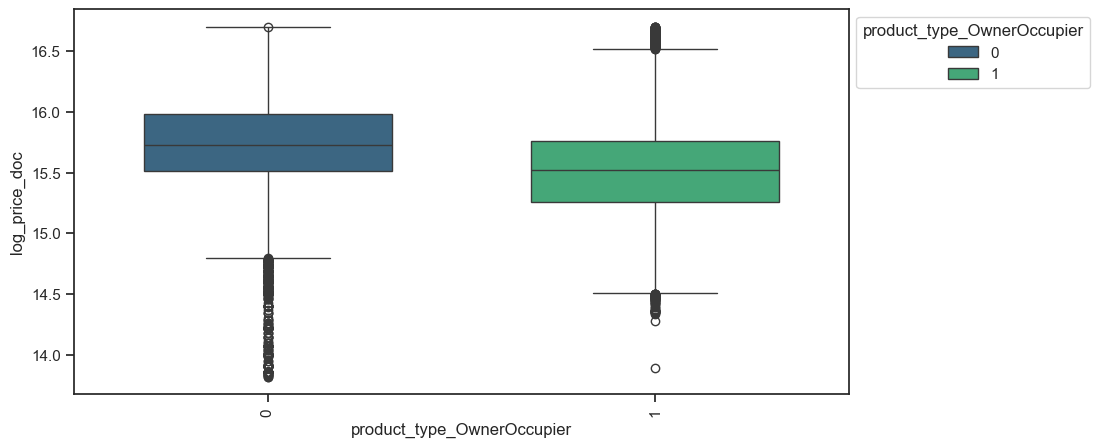

In [520]:
plt.figure(figsize = (10,5))
sns.set_theme(style="ticks", palette="pastel")
ax = sns.boxplot(y = 'log_price_doc', x = data['product_type_OwnerOccupier'].astype('category'), data = data, hue='product_type_OwnerOccupier', palette='viridis', gap=.2)
plt.setp(ax.get_xticklabels(), rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Хорошо видно, медианные значения сильно отличаются, как и выбросы.

Поделим наш датасет на два сегмента Owner_Occupier и Investment

In [521]:
Owner_Occupier = data[data['product_type_OwnerOccupier'] == 1].copy()
Investment = data[data['product_type_OwnerOccupier'] == 0].copy()

X_Occupier, X_Investment = Owner_Occupier.drop('log_price_doc', axis=1), Investment.drop('log_price_doc', axis=1)
Y_Occupier, Y_Investment = Owner_Occupier['log_price_doc'], Investment['log_price_doc']

Тепереь построим модель сначала для сегмента Owner_Occupier

In [522]:
# создаем объект калсса TimeSeriesSplit для деления датасета на фолды по времени, аргумент n_splits - кол-во фолдов
splitter_for_Occupier = TimeSeriesSplit(n_splits=4)

# создаем список значений гиперпараметра, который будем перебирать
alphas = np.linspace(0.0001, 5, 30)

# создаем конструктор - объект класса Pipeline и передаем в него последовательность действий как список кортежей:
# сначала делаем масштабирование StandardScaler, затем делаем регуляризацию Lasso и строим модель линейной регрессии
pipeline_of_ML = Pipeline(
    [
        ('scaler', RobustScaler()),
        ('Lasso', Lasso(max_iter=1000000)) 
    ]
)
# tol представляет собой минимальное изменение целевой функции или параметров модели между итерациями, 
# при котором алгоритм продолжает работу. Для Lasso регрессии в scikit-learn значение толерантности по умолчанию составляет 1e-4
# 

# задаем словарик с гиперпараметрами
param_grid = {"Lasso__alpha": alphas}

# создаем объект класса GridSearchCV и передаем ему объект pipeline_of_ML, где у нас прописана последовательность действий,
# затем передаем словарь с гиперпараметрами, затем передаем объект класса TimeSeriesSplit, который делит датасет на фолды по времени,
# далее передаем метрику, по которой будем оценивать качество модели - в аданном случае это MSLE, так как у нас логарифм таргета
search_Owner_Occupier = GridSearchCV(pipeline_of_ML, param_grid, cv=splitter_for_Occupier, scoring='neg_mean_squared_error')

# передаем наши данные
search_Owner_Occupier.fit(X_Occupier, Y_Occupier)

print(f'Best parameter for Owner_Occupier segment (Cross-validation score = {search_Owner_Occupier.best_score_:.5f}):')
print(search_Owner_Occupier.best_params_)

# убеждаемся, что все посчитано верно
pipeline_of_ML.set_params(Lasso__alpha = search_Owner_Occupier.best_params_['Lasso__alpha'])

cv_result_pipe = cross_validate(pipeline_of_ML, 
                                X_Occupier, 
                                Y_Occupier, 
                                cv=splitter_for_Occupier, 
                                scoring='neg_mean_squared_error', 
                                return_train_score=True)

MSLE_error_Occupier_train = -np.mean(cv_result_pipe['train_score'])
MSLE_error_Occupier_test = -np.mean(cv_result_pipe['test_score'])

print(f'MSLE on train for Occupier segment: {MSLE_error_Occupier_train}')
print(f'MSLE on test for Occupier segment: {MSLE_error_Occupier_test}')

C:\Users\KatAndr\YandexDisk\2024\ML_Engeneer\Classical_ML\venv_for_classical_ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+01, tolerance: 3.018e-02
  model = cd_fast.enet_coordinate_descent(


Best parameter for Owner_Occupier segment (Cross-validation score = -0.14380):
{'Lasso__alpha': np.float64(0.1725103448275862)}
MSLE on train for Occupier segment: 0.09199513258821386
MSLE on test for Occupier segment: 0.14379765385908228


Получили предупреждение, что алгоритм не сходится, значит нужно попробовать поменять параметры при построении модели.

Поговорим про параметры модели Lasso:

***Солвер (solver)***

- это алгоритм оптимизации, который используется для нахождения оптимальных параметров модели путем минимизации функции потерь.
Солверы для Lasso в scikit-learn:

**'coordinate_descent'** (по умолчанию):
Алгоритм координатного спуска.
Эффективен для задач с небольшим или средним количеством признаков.
Хорошо работает, когда матрица признаков разреженная.

**'lbfgs'**: Ограниченный алгоритм Бройдена — Флетчера — Гольдфарба — Шанно (L-BFGS).
Эффективен для задач с большим количеством признаков.
Может быть быстрее, чем coordinate_descent для плотных данных.

**'saga'**:
Вариант стохастического градиентного спуска.
Эффективен для больших наборов данных.
Хорошо работает с разреженными данными и может обрабатывать L1 регуляризацию.

**'lars'** (Least Angle Regression):
Специфичный алгоритм для Lasso.
Эффективен для задач с высокой размерностью, но небольшим количеством ненулевых коэффициентов.

***Различия между солверами***:

*Скорость сходимости*:
'coordinate_descent' обычно быстр для задач среднего размера.
'lbfgs' может быть быстрее для задач с большим числом признаков.
'saga' эффективен для больших наборов данных.
'lars' может быть очень быстрым для разреженных решений.

*Память*:
'coordinate_descent' и 'lars' обычно требуют меньше памяти.
'lbfgs' может требовать больше памяти для больших задач.
'saga' имеет умеренные требования к памяти.

*Точность*:
'coordinate_descent' и 'lbfgs' обычно дают точные результаты.
'saga' может требовать больше итераций для достижения той же точности.
'lars' точен, особенно для разреженных решений.

*Масштабируемость*:
'saga' лучше масштабируется на большие наборы данных.
'lbfgs' хорошо работает с большим количеством признаков.

Когда какой солвер применять:

*'coordinate_descent'*:
Для большинства задач среднего размера.
Когда данные разрежены.

*'lbfgs'*:
Для задач с большим количеством признаков.
Когда данные плотные.

*'saga'*:
Для очень больших наборов данных.
Когда требуется обработка онлайн или потоковых данных.

*'lars'*:
Когда ожидается очень разреженное решение.
Для задач с высокой размерностью, но малым числом значимых признаков.

***Толерантность (tol)*** 

- это параметр, который определяет критерий остановки алгоритма оптимизации, то есть это пороговое значение для определения, когда алгоритм считается сошедшимся. Оно представляет собой минимальное изменение целевой функции или параметров модели между итерациями, при котором алгоритм продолжает работу.

*Значение по умолчанию*:

Для Lasso регрессии в scikit-learn значение толерантности по умолчанию составляет 1e-4 или 0.0001.

*Влияние на алгоритм*:

Меньшее значение tol заставляет алгоритм работать дольше, стремясь к более точному решению.
Большее значение tol может привести к более быстрой сходимости, но потенциально менее точному решению.

*Когда изменять*:

Уменьшение tol может помочь, если алгоритм не сходится или вы нуждаетесь в более точном решении.
Увеличение tol может быть полезно, если алгоритм работает слишком долго, а небольшая потеря в точности приемлема.

*Взаимосвязь с другими параметрами*:

Толерантность часто работает в паре с max_iter (максимальным числом итераций). Алгоритм останавливается, когда достигнута толерантность или выполнено максимальное число итераций.

**Важно**: изменение толерантности - это баланс между точностью и временем выполнения. Слишком маленькое значение может привести к очень долгому времени выполнения, а слишком большое - к неоптимальному решению.

Какими способами можно побороть проблему сходимости? Рассмотрим возможные причины и способы решения этой проблемы:

- Увеличение числа итераций:
У нас уже max_iter=1000000, что достаточно много. Однако, можно попробовать еще увеличить это значение:
```python
('Lasso', Lasso(max_iter=5000000))
```

- Масштабирование признаков:
Мы уже используем RobustScaler(), что хорошо. Однако, можно попробовать другие методы масштабирования, например StandardScaler или MinMaxScaler:
```python
('scaler', StandardScaler())
('scaler', MinMaxScaler())
```

- Увеличение регуляризации:
Можно попробовать расширить диапазон значений alpha:
```python
alphas = np.logspace(-4, 2, 30)
```

- Проверка и обработка выбросов:
RobustScaler должен справляться с выбросами, но возможно стоит дополнительно проверить данные на наличие экстремальных значений.

- Уменьшение толерантности:
Можно попробовать уменьшить значение tol:
```python
('Lasso', Lasso(max_iter=1000000, tol=1e-5))
```

- Использование другого солвера:

По умолчанию Lasso использует координатный спуск, но можно попробовать другой метод оптимизации:
```python
('Lasso', Lasso(max_iter=1000000, solver='saga'))
```

- Проверка мультиколлинеарности:
Если между признаками есть сильная корреляция, это может затруднить сходимость. Можно рассмотреть возможность удаления сильно коррелирующих признаков или использования методов снижения размерности.

- Использование ElasticNet:
ElasticNet сочетает L1 и L2 регуляризацию и иногда может быть более стабильным:
```python
from sklearn.linear_model import ElasticNet
('ElasticNet', ElasticNet(max_iter=1000000))
```

Попробуем применить эти решения по очереди или в комбинации. После каждого изменения запускаем код и смотрим, исчезло ли предупреждение.

In [523]:
# Увеличили кол-во итераций max_iter=5000000
splitter_for_Occupier = TimeSeriesSplit(n_splits=4)

alphas = np.linspace(0.0001, 5, 30)

pipeline_of_ML = Pipeline(
    [
        ('scaler', RobustScaler()),
        ('Lasso', Lasso(max_iter=5000000)) 
    ]
)

param_grid = {"Lasso__alpha": alphas}

search_Owner_Occupier = GridSearchCV(pipeline_of_ML, param_grid, cv=splitter_for_Occupier, scoring='neg_mean_squared_error')

search_Owner_Occupier.fit(X_Occupier, Y_Occupier)

print(f'Best parameter for Owner_Occupier segment (Cross-validation score = {search_Owner_Occupier.best_score_:.5f}):')
print(search_Owner_Occupier.best_params_)

pipeline_of_ML.set_params(Lasso__alpha = search_Owner_Occupier.best_params_['Lasso__alpha'])

cv_result_pipe = cross_validate(pipeline_of_ML, 
                                X_Occupier, 
                                Y_Occupier, 
                                cv=splitter_for_Occupier, 
                                scoring='neg_mean_squared_error', 
                                return_train_score=True)

MSLE_error_Occupier_train = -np.mean(cv_result_pipe['train_score'])
MSLE_error_Occupier_test = -np.mean(cv_result_pipe['test_score'])

print(f'MSLE on train for Occupier segment: {MSLE_error_Occupier_train}')
print(f'MSLE on test for Occupier segment: {MSLE_error_Occupier_test}')

Best parameter for Owner_Occupier segment (Cross-validation score = -0.14380):
{'Lasso__alpha': np.float64(0.1725103448275862)}
MSLE on train for Occupier segment: 0.09199513258821386
MSLE on test for Occupier segment: 0.14379765385908228


Простое увеличение числа итераций привело к решение проблемы! Более того, модель на сегменте показала еще более лучший результат

In [283]:
search_Owner_Occupier.best_params_ # здесь словарь с оптимальными параметрами

{'Lasso__alpha': np.float64(0.001)}

In [284]:
search_Owner_Occupier.best_score_ # здесь словарь с значением выбранной метрики при оптимальном параметре

np.float64(-0.07113900562056137)

In [285]:
search_Owner_Occupier.best_estimator_ # здесь последовательность шагов

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=np.float64(0.001), max_iter=100000))])

Теперь строим модель для сегмента Investment

In [524]:
#splitter_for_Investment = TimeSeriesSplit(n_splits=4)

search_Investment = GridSearchCV(pipeline_of_ML, param_grid, cv=splitter_for_Occupier, scoring='neg_mean_squared_error')

search_Investment.fit(X_Investment, Y_Investment)

print(f'Best parameter (Cross-validation score = {search_Investment.best_score_:.5f}):')
print(search_Investment.best_params_)

pipeline_of_ML.set_params(Lasso__alpha = search_Investment.best_params_['Lasso__alpha'])

cv_result_pipe = cross_validate(pipeline_of_ML, 
                                X_Investment, 
                                Y_Investment, 
                                cv=splitter_for_Investment, 
                                scoring='neg_mean_squared_error', 
                                return_train_score=True)

MSLE_error_Investment_train = -np.mean(cv_result_pipe['train_score'])
MSLE_error_Investment_test = -np.mean(cv_result_pipe['test_score'])

print(f'MSLE on train for Investment segment: {MSLE_error_Investment_train}')
print(f'MSLE on test for Investment segment: {MSLE_error_Investment_test}')

Best parameter (Cross-validation score = -0.18685):
{'Lasso__alpha': np.float64(0.0001)}
MSLE on train for Investment segment: 0.17560436367105475
MSLE on test for Investment segment: 0.18685410993309723


Для сегмента Investment ошибка получилась чуть больше

Теперь посчитаем среднюю ошибку наших двух моделей  - то есть посмотрим, как модели работают в коллаборации:

In [526]:
n_Occupier = Owner_Occupier.shape[0] # кол-во объектов сегмента Occupier
n_Investment = Investment.shape[0] # кол-во объектов сегмента Investment
print(f'{n_Occupier} + {n_Investment} = {n_Occupier+n_Investment} = {data.shape[0]}')

10792 + 17937 = 28729 = 28729


In [527]:
# как эти две модели ошибаются в коллаборации
n_Occupier = Owner_Occupier.shape[0] # кол-во объектов сегмента Occupier
n_Investment = Investment.shape[0] # кол-во объектов сегмента Investment

#Доля категорий в общей выборке:

share_Occupier = n_Occupier / (n_Occupier + n_Investment)
share_Investment = n_Occupier / (n_Occupier + n_Investment)

weighted_error_train = share_Occupier * MSLE_error_Occupier_train + share_Investment * MSLE_error_Investment_train
weighted_error_test = share_Occupier * MSLE_error_Occupier_test + share_Investment * MSLE_error_Investment_test

print(f'Среднее взвешенное MSLE на тренировочных фолдах: {weighted_error_train.round(2)}')
print(f'Среднее взвешенное MSLE на тестовых фолдах: {weighted_error_test.round(2)}')

Среднее взвешенное MSLE на тренировочных фолдах: 0.1
Среднее взвешенное MSLE на тестовых фолдах: 0.12


Таким образом, средневзвешенная ошибка еще уменьшилась. Построим итоговый график:

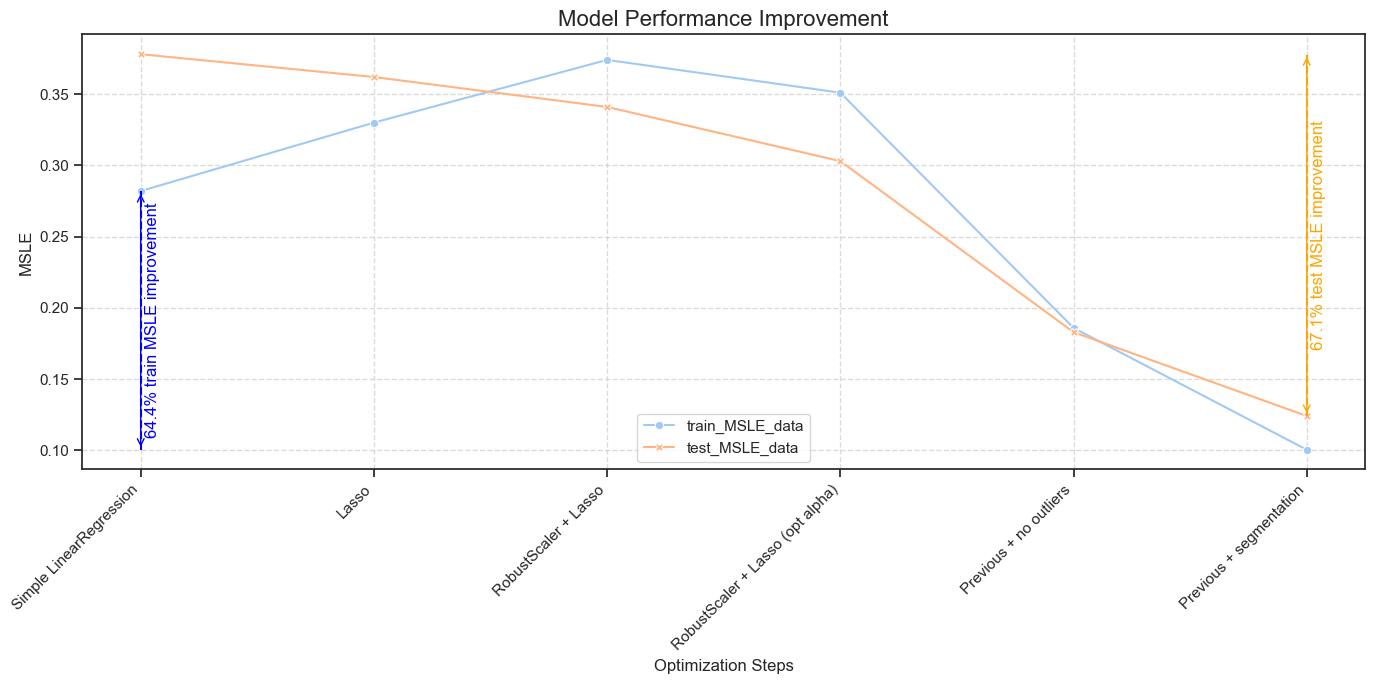

In [558]:
# Определим названия шагов
steps = [
    'Simple LinearRegression',
    'Lasso',
    'RobustScaler + Lasso',
    'RobustScaler + Lasso (opt alpha)',
    'Previous + no outliers',
    'Previous + segmentation'
]

# Создадим фигуру большего размера
plt.figure(figsize=(14, 7))

# Построим график
sns.lineplot(data=All_MSLE_data, markers=True, dashes=False)

# Настроим оси
plt.xticks(range(len(steps)), steps, rotation=45, ha='right')
plt.xlabel('Optimization Steps')
plt.ylabel('MSLE')

# Добавим заголовок
plt.title('Model Performance Improvement', fontsize=16)

# Добавим легенду
plt.legend()

# Добавим сетку для лучшей читаемости
plt.grid(True, linestyle='--', alpha=0.7)

# Рассчитаем процентное улучшение
train_improvement = (All_MSLE_data['train_MSLE_data'].iloc[0] - All_MSLE_data['train_MSLE_data'].iloc[-1]) / All_MSLE_data['train_MSLE_data'].iloc[0] * 100
test_improvement = (All_MSLE_data['test_MSLE_data'].iloc[0] - All_MSLE_data['test_MSLE_data'].iloc[-1]) / All_MSLE_data['test_MSLE_data'].iloc[0] * 100

# Добавим вертикальные линии и аннотации
for y_pos, x_pos, column, color, text_data in zip([All_MSLE_data[column].iloc[0], All_MSLE_data[column].iloc[-1]], [0,5], ['train_MSLE_data', 'test_MSLE_data'], ['blue', 'orange'], ['train MSLE', 'test MSLE']):
    start = All_MSLE_data[column].iloc[0]
    end = All_MSLE_data[column].iloc[-1]
    improvement = (start - end) / start * 100
    
    plt.vlines(x=x_pos, ymin=end, ymax=start, colors=color, linestyles='dashed')
    plt.hlines(y=x_pos, xmin=0, xmax=5, colors=color, linestyles='dashed')

    # Добавим стрелки
    plt.annotate('', xy=(x_pos, start), xytext=(x_pos, end),
                 arrowprops=dict(arrowstyle='<->', color=color))
    
    # Добавим аннотацию вдоль линии
    mid_y = (start + end) / 2
    plt.annotate(f'{improvement:.1f}% {text_data} improvement', 
                 xy=(x_pos, mid_y), 
                 xytext=(3, 0), 
                 textcoords='offset points',
                 ha='left', 
                 va='center',
                 color=color,
                 rotation=90)

# Улучшим расположение элементов
plt.tight_layout()

# Отобразим график
plt.show()